<a href="https://colab.research.google.com/github/PyAshishMhatre/DigitalMarketing-Algorithms-Project/blob/main/DemandForcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [38]:
#Reading data 
distribution_centers = pd.read_csv('distribution_centers.csv')
inventory_items = pd.read_csv('inventory_items.csv')
order_items = pd.read_csv('order_items.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
users = pd.read_csv('users.csv')

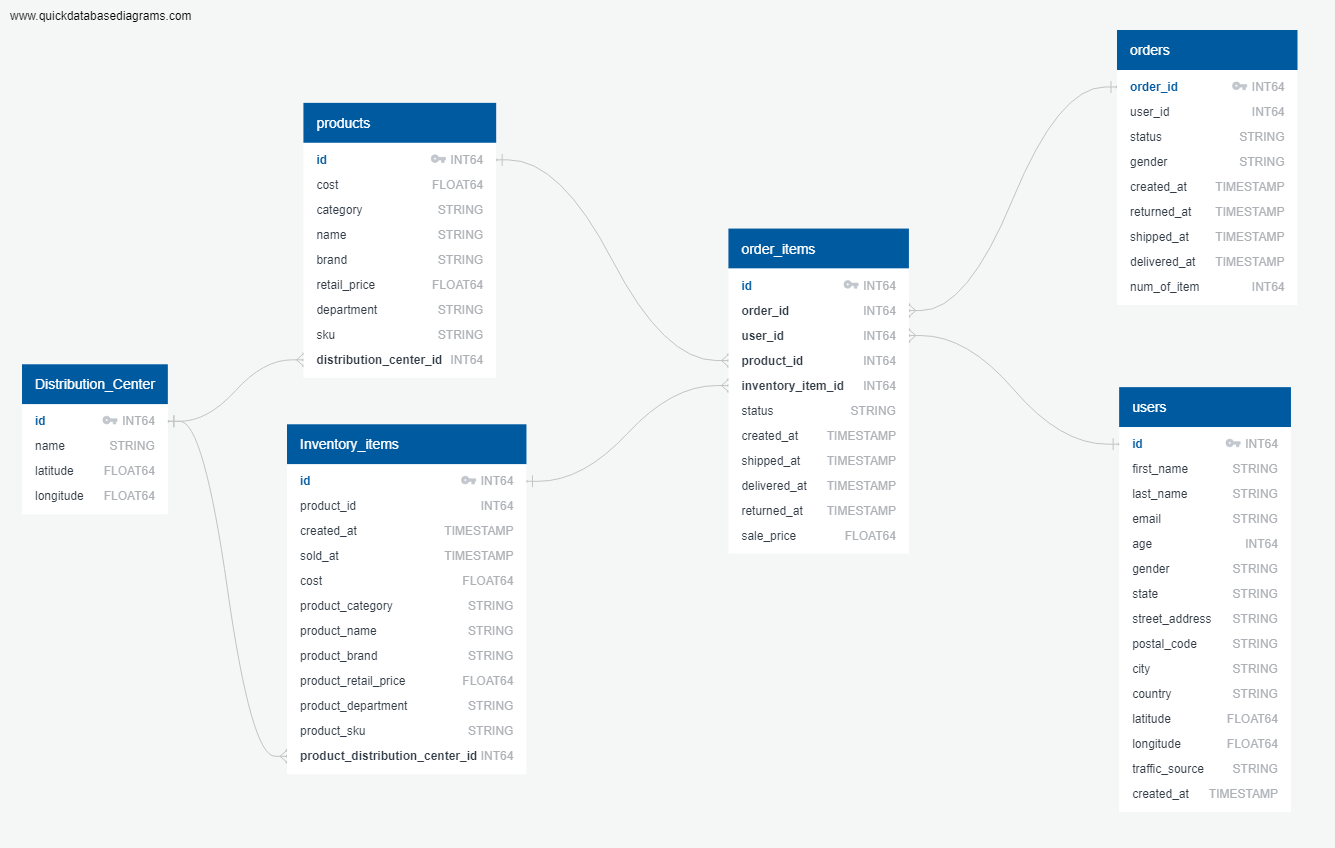

# Analysis

In [ ]:
# Ploting the timeline for count of items sold by product type

count_product = order_items.groupby(['created_at', 'product_id']).size().reset_index(name='count')
count_product = count_product.sort_values(by = ['created_at', 'product_id'])

In [ ]:
print(count_product.head())

print('\n We have {a} unique products'.format(a = len(count_product['product_id'].unique())))

                created_at  product_id  count
0  2019-01-06 04:19:39 UTC       28643      1
1  2019-01-06 08:46:59 UTC       20835      1
2  2019-01-07 07:27:40 UTC       23736      1
3  2019-01-09 04:02:14 UTC       23959      1
4  2019-01-10 04:28:59 UTC        4074      1

 We have 29057 unique products


## Analysing 29057 is difficult and we wont be forecasting data at such granular level thus we will merge the dataset with products to get a broader category to work with forecasting 

Checking what can be our broader category for analysis

In [ ]:
len(products['category'].unique())

# Since category has a workable count we will consider category as our agg variable

26

In [ ]:
print(' \n Length before merging ',len(order_items))

order_items_product = pd.merge(order_items, inventory_items, how='inner', left_on='inventory_item_id', right_on='id')

print(' \n Length after merging ',len(order_items_product))

 
 Length before merging  181622
 
 Length after merging  181622


In [ ]:
order_items_product.head(2)

,id_x,order_id,user_id,product_id_x,inventory_item_id,status,created_at_x,shipped_at,delivered_at,returned_at,...,created_at_y,sold_at,cost,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id
0,82431,56667,45224,13606,222767,Returned,2022-08-07 06:27:15 UTC,2022-08-08 06:10:00 UTC,2022-08-12 12:50:00 UTC,2022-08-13 19:51:00 UTC,...,2022-10-31 10:27:00 UTC,NaN,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,2.5,Women,4ACBEDBE977480D19B7B682D4878CAE2,3
1,76930,52883,42129,28951,207892,Shipped,2022-12-31 05:59:28 UTC,2022-12-31 00:13:00 UTC,NaN,NaN,...,2021-04-13 07:24:00 UTC,NaN,1.2690,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades,3.0,Men,110EED2C630AAB0F3FA87D6473926732,6


In [ ]:
order_items_product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181622 entries, 0 to 181621
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id_x                            181622 non-null  int64  
 1   order_id                        181622 non-null  int64  
 2   user_id                         181622 non-null  int64  
 3   product_id_x                    181622 non-null  int64  
 4   inventory_item_id               181622 non-null  int64  
 5   status                          181622 non-null  object 
 6   created_at_x                    181622 non-null  object 
 7   shipped_at                      117819 non-null  object 
 8   delivered_at                    63723 non-null   object 
 9   returned_at                     18378 non-null   object 
 10  sale_price                      181622 non-null  float64
 11  id_y                            181622 non-null  int64  
 12  product_id_y    

In [ ]:
# Converting to date time 
order_items_product['created_at_x'] = pd.to_datetime(order_items_product['created_at_x'], utc=True)

In [ ]:
order_items_product['created_at_x'].info()

<class 'pandas.core.series.Series'>
Int64Index: 181622 entries, 0 to 181621
Series name: created_at_x
Non-Null Count   Dtype              
--------------   -----              
181622 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1)
memory usage: 2.8 MB


In [ ]:
order_items_product.head(2)

,id_x,order_id,user_id,product_id_x,inventory_item_id,status,created_at_x,shipped_at,delivered_at,returned_at,...,created_at_y,sold_at,cost,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id
0,82431,56667,45224,13606,222767,Returned,2022-08-07 06:27:15+00:00,2022-08-08 06:10:00 UTC,2022-08-12 12:50:00 UTC,2022-08-13 19:51:00 UTC,...,2022-10-31 10:27:00 UTC,NaN,1.1075,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,2.5,Women,4ACBEDBE977480D19B7B682D4878CAE2,3
1,76930,52883,42129,28951,207892,Shipped,2022-12-31 05:59:28+00:00,2022-12-31 00:13:00 UTC,NaN,NaN,...,2021-04-13 07:24:00 UTC,NaN,1.2690,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades,3.0,Men,110EED2C630AAB0F3FA87D6473926732,6


In [ ]:
order_items_product['year'] = order_items_product['created_at_x'].dt.year
order_items_product['month'] = order_items_product['created_at_x'].dt.month
order_items_product['day'] = order_items_product['created_at_x'].dt.day

In [ ]:
order_items_product.head(2)

,id_x,order_id,user_id,product_id_x,inventory_item_id,status,created_at_x,shipped_at,delivered_at,returned_at,...,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id,year,month,day
0,82431,56667,45224,13606,222767,Returned,2022-08-07 06:27:15+00:00,2022-08-08 06:10:00 UTC,2022-08-12 12:50:00 UTC,2022-08-13 19:51:00 UTC,...,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,2.5,Women,4ACBEDBE977480D19B7B682D4878CAE2,3,2022,8,7
1,76930,52883,42129,28951,207892,Shipped,2022-12-31 05:59:28+00:00,2022-12-31 00:13:00 UTC,NaN,NaN,...,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades,3.0,Men,110EED2C630AAB0F3FA87D6473926732,6,2022,12,31


In [ ]:
count_productcat = order_items_product.groupby(['year','month','product_category']).size().reset_index(name='count')
count_productcat = count_productcat.sort_values(by = ['year','month', 'product_category'])

In [ ]:
count_productcat.head(5)

,year,month,product_category,count
0,2019,1,Accessories,3
1,2019,1,Active,2
2,2019,1,Fashion Hoodies & Sweatshirts,2
3,2019,1,Intimates,2
4,2019,1,Jeans,3


In [ ]:
# convert the 'year' and 'month' columns to a datetime format
count_productcat['date'] = pd.to_datetime(count_productcat['year'].astype(str) + '-' + count_productcat['month'].astype(str), format='%Y-%m')
count_productcat = count_productcat.drop(['year', 'month'], axis=1)



In [ ]:
count_productcat.head(5)

,product_category,count,date
0,Accessories,3,2019-01-01
1,Active,2,2019-01-01
2,Fashion Hoodies & Sweatshirts,2,2019-01-01
3,Intimates,2,2019-01-01
4,Jeans,3,2019-01-01


In [ ]:
count_productcat['product_category'].unique()

array(['Accessories', 'Active', 'Fashion Hoodies & Sweatshirts',
       'Intimates', 'Jeans', 'Jumpsuits & Rompers', 'Leggings',
       'Outerwear & Coats', 'Pants', 'Shorts', 'Sleep & Lounge', 'Socks',
       'Socks & Hosiery', 'Suits & Sport Coats', 'Sweaters', 'Swim',
       'Underwear', 'Blazers & Jackets', 'Clothing Sets', 'Dresses',
       'Maternity', 'Pants & Capris', 'Plus', 'Skirts', 'Suits',
       'Tops & Tees'], dtype=object)

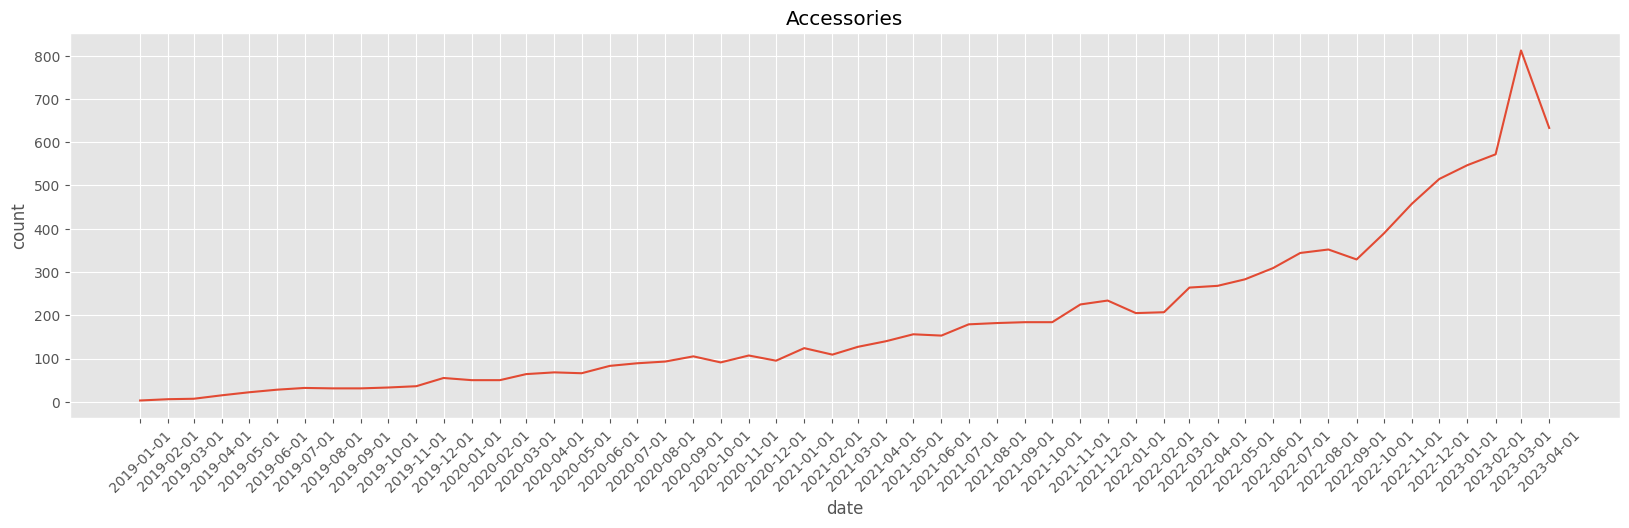

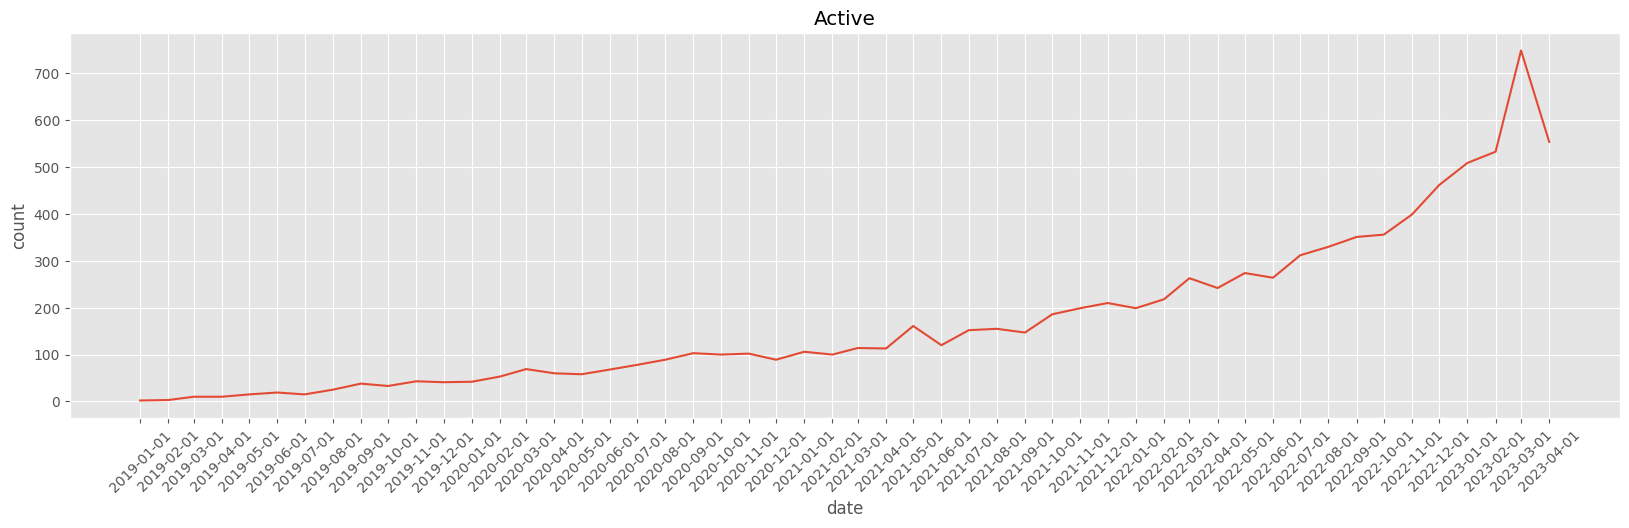

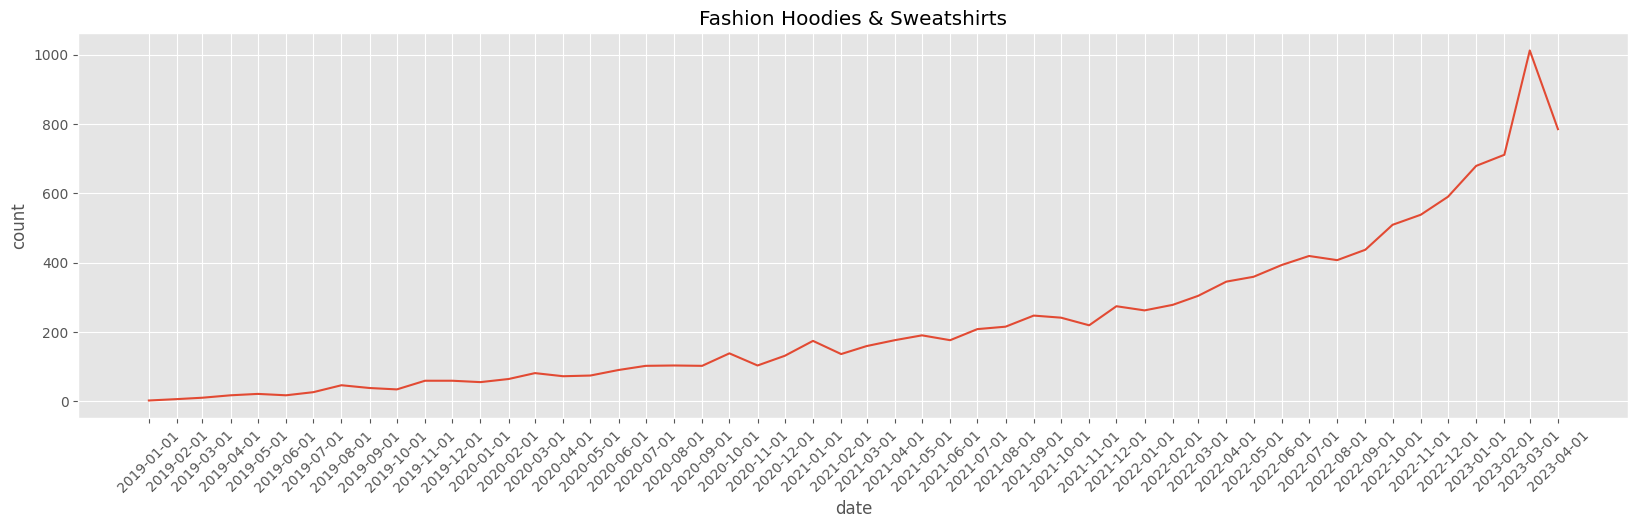

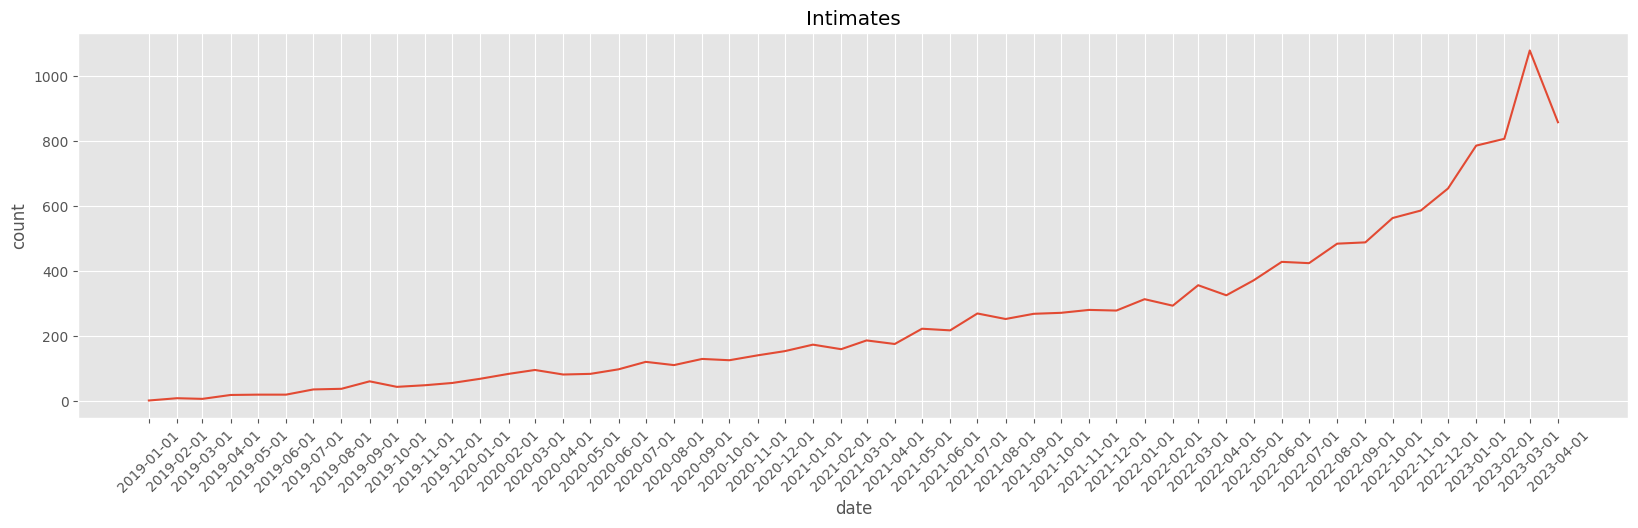

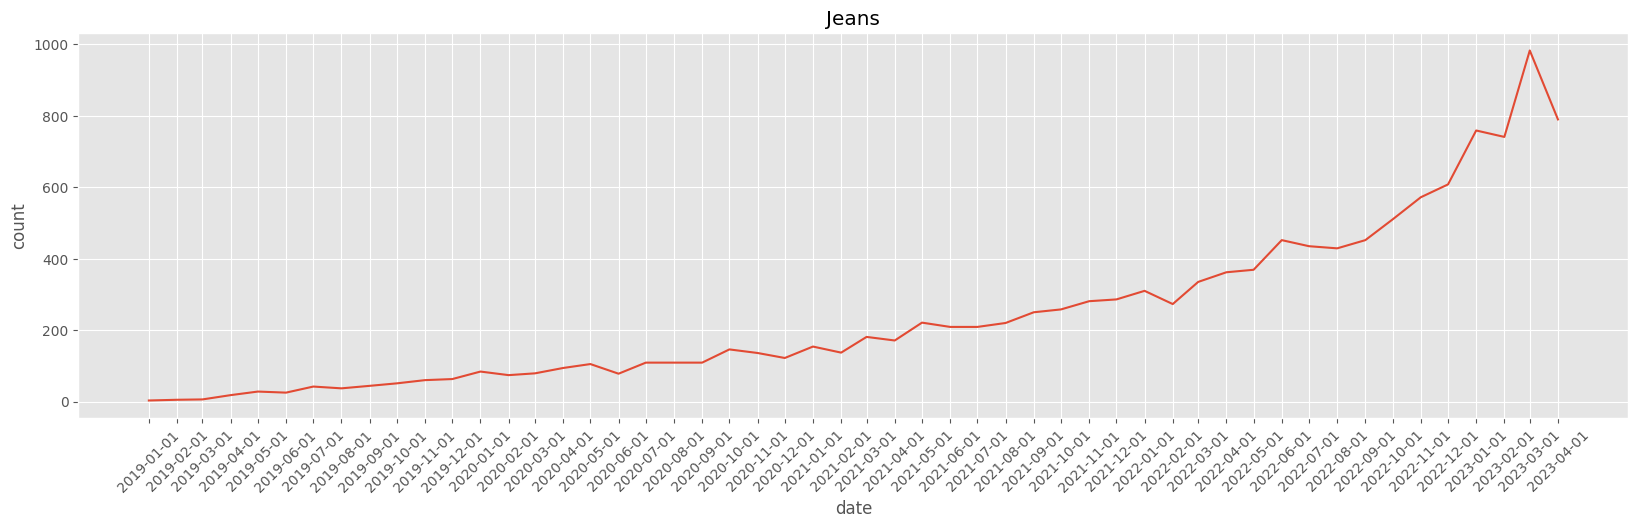

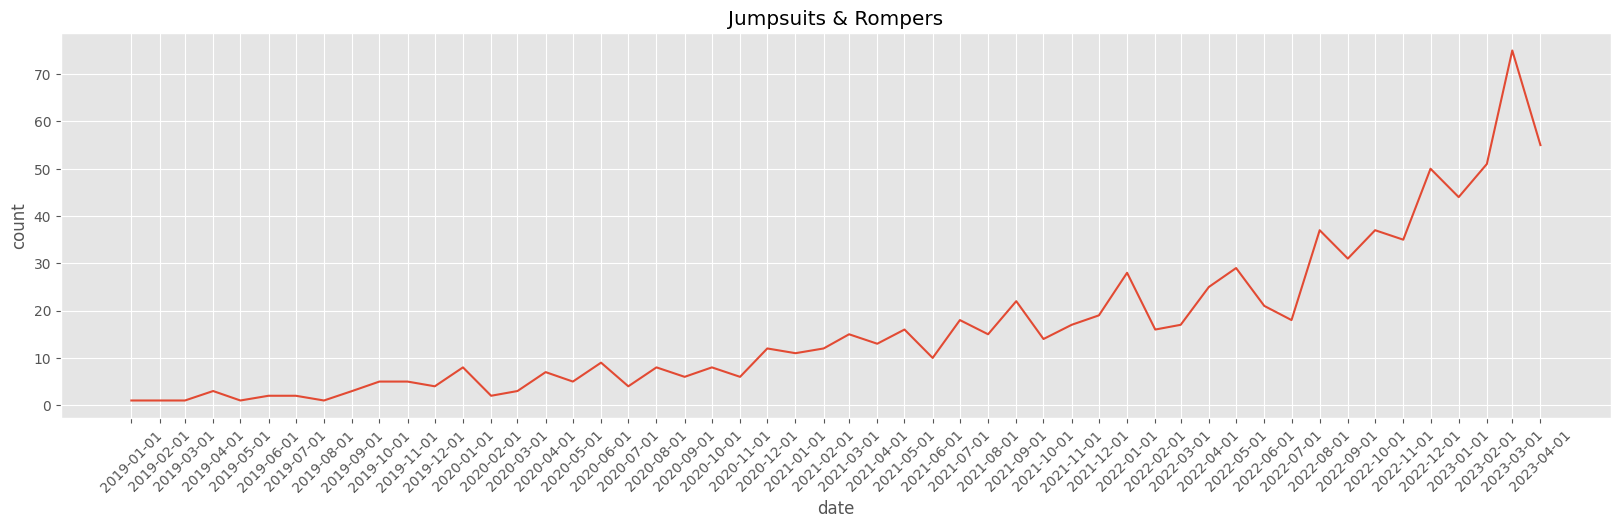

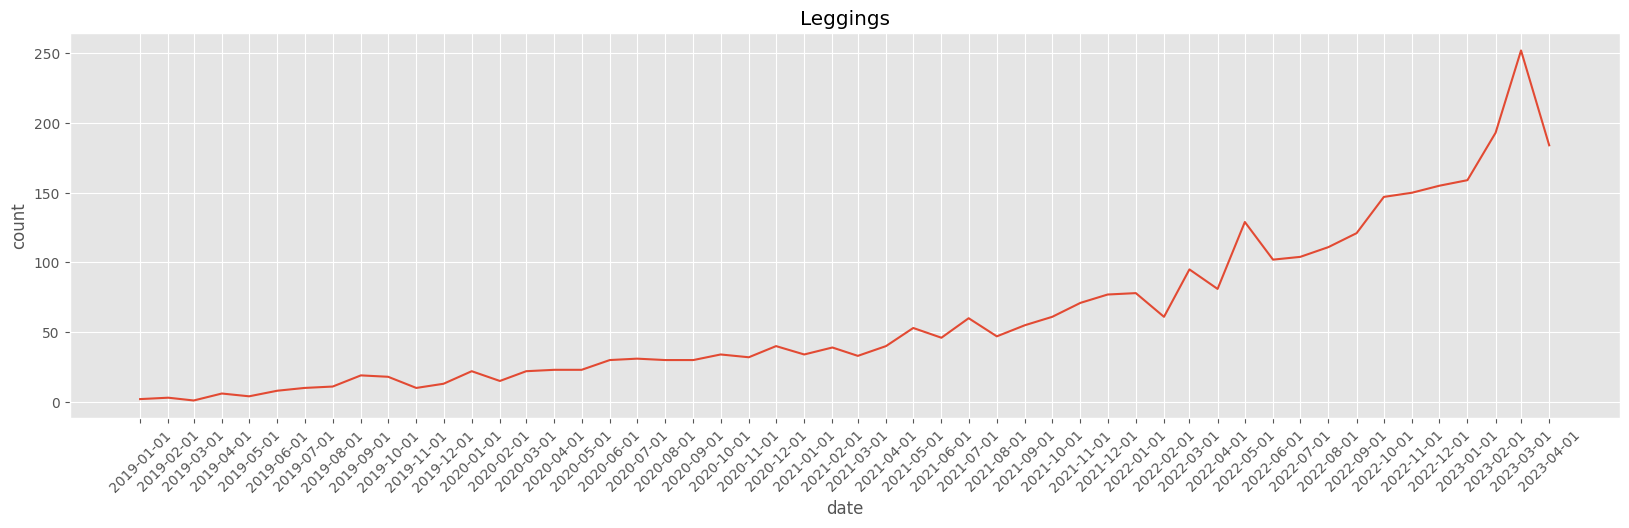

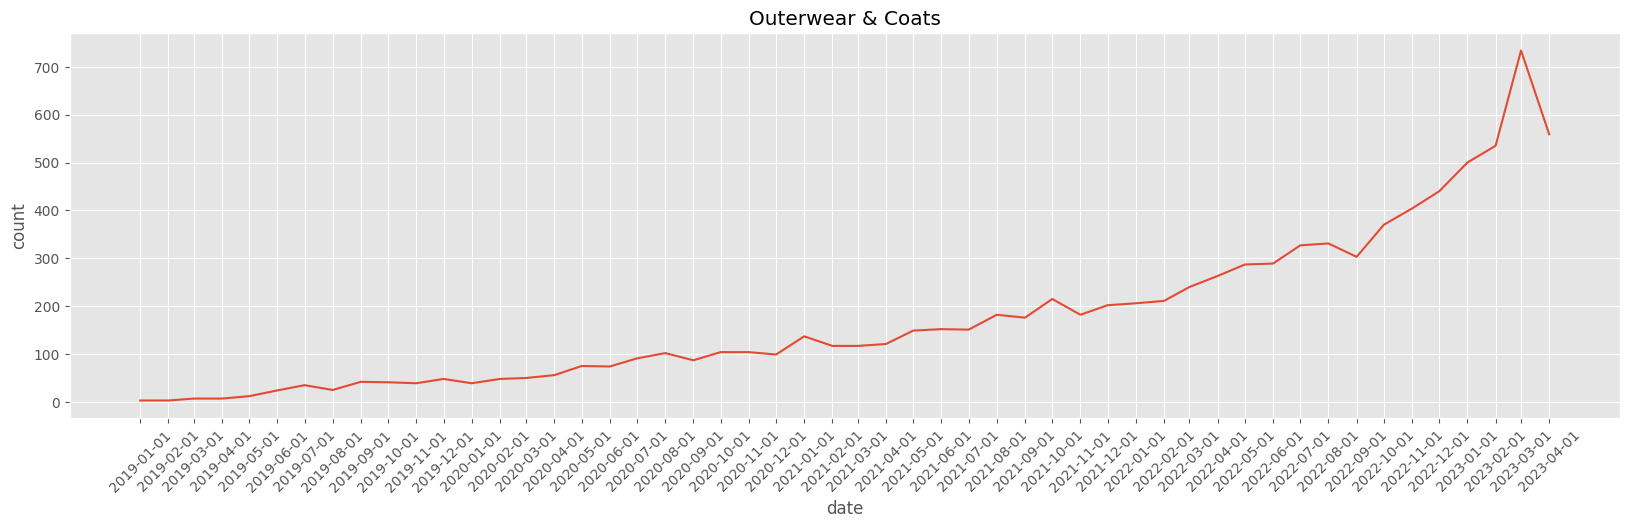

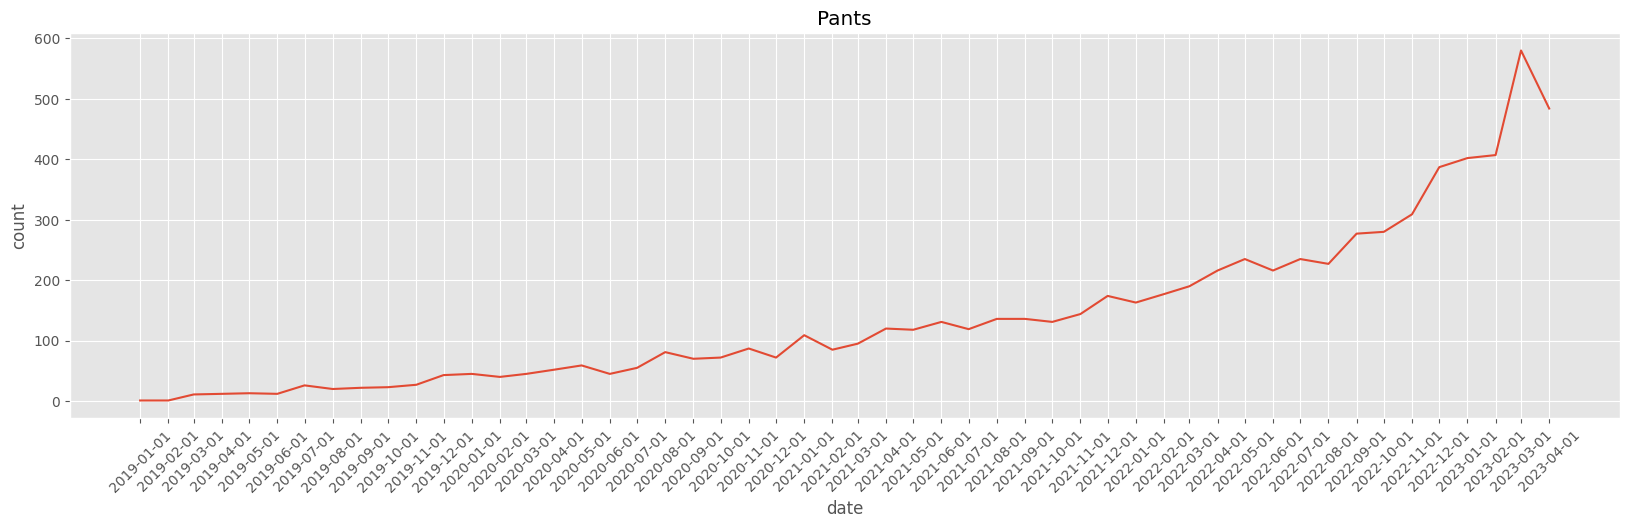

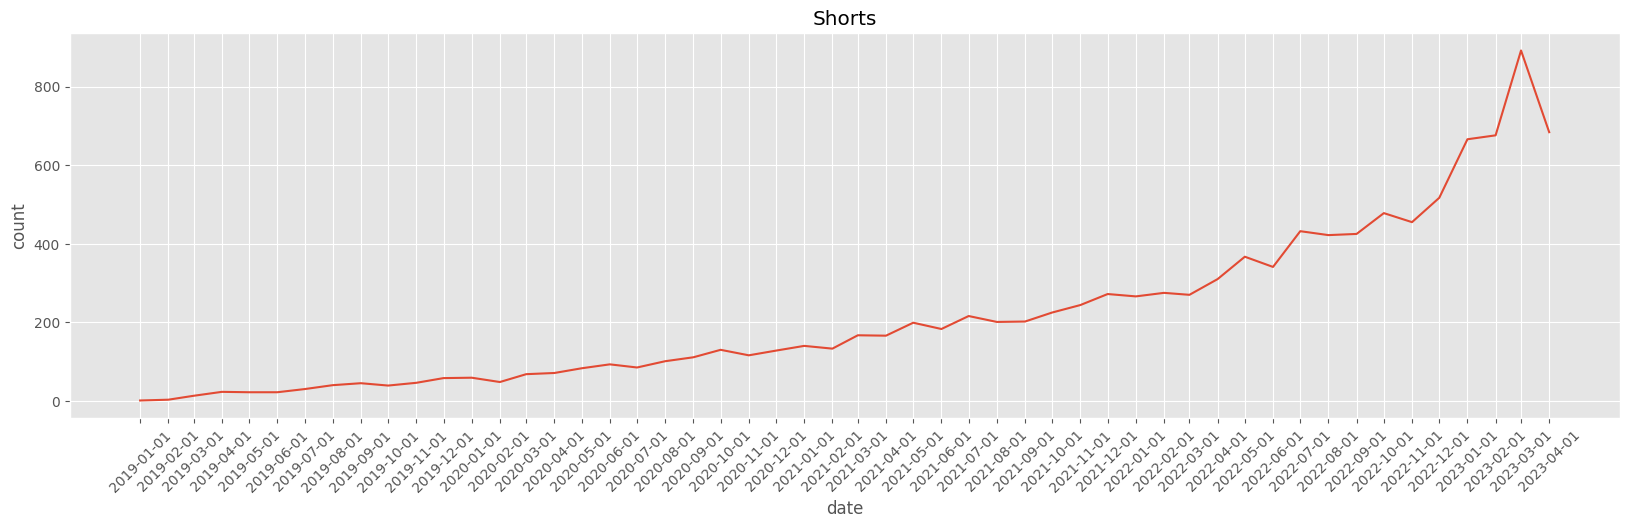

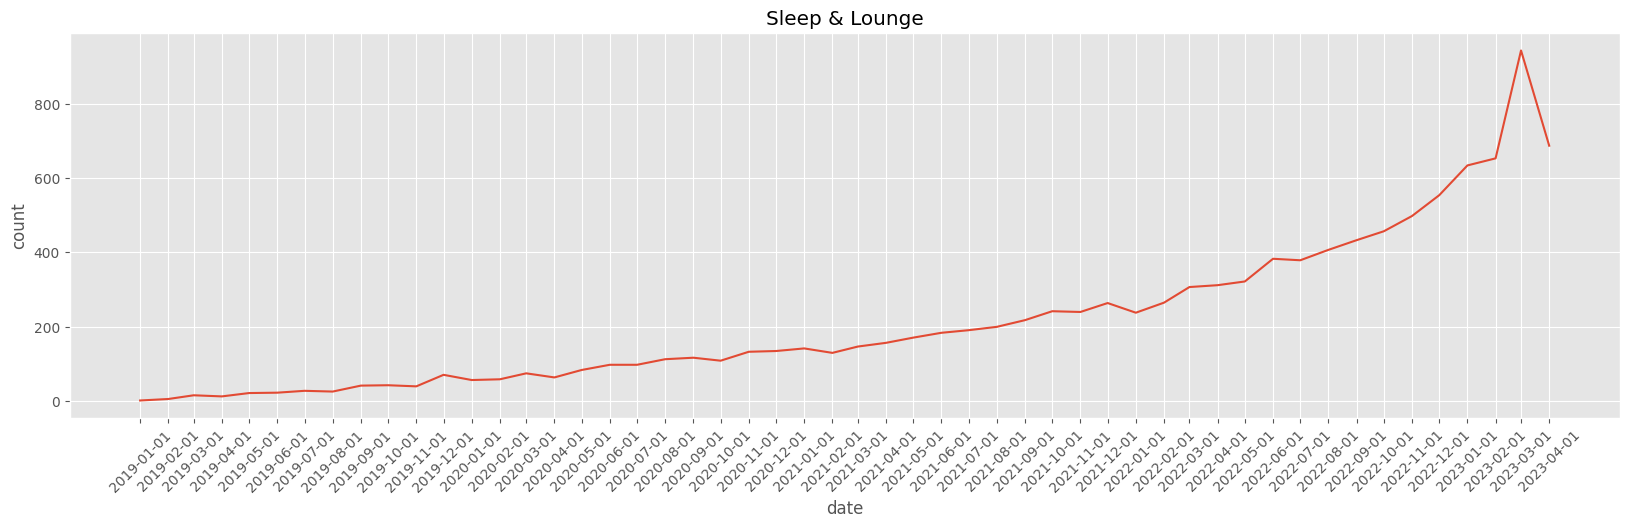

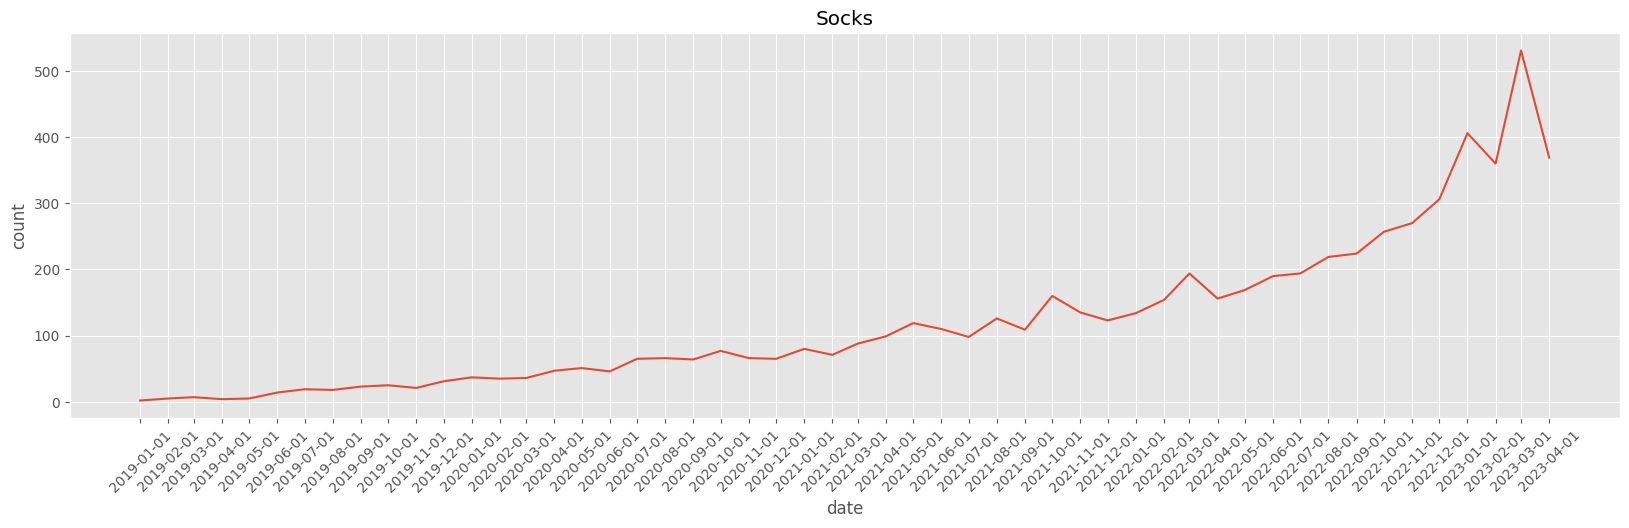

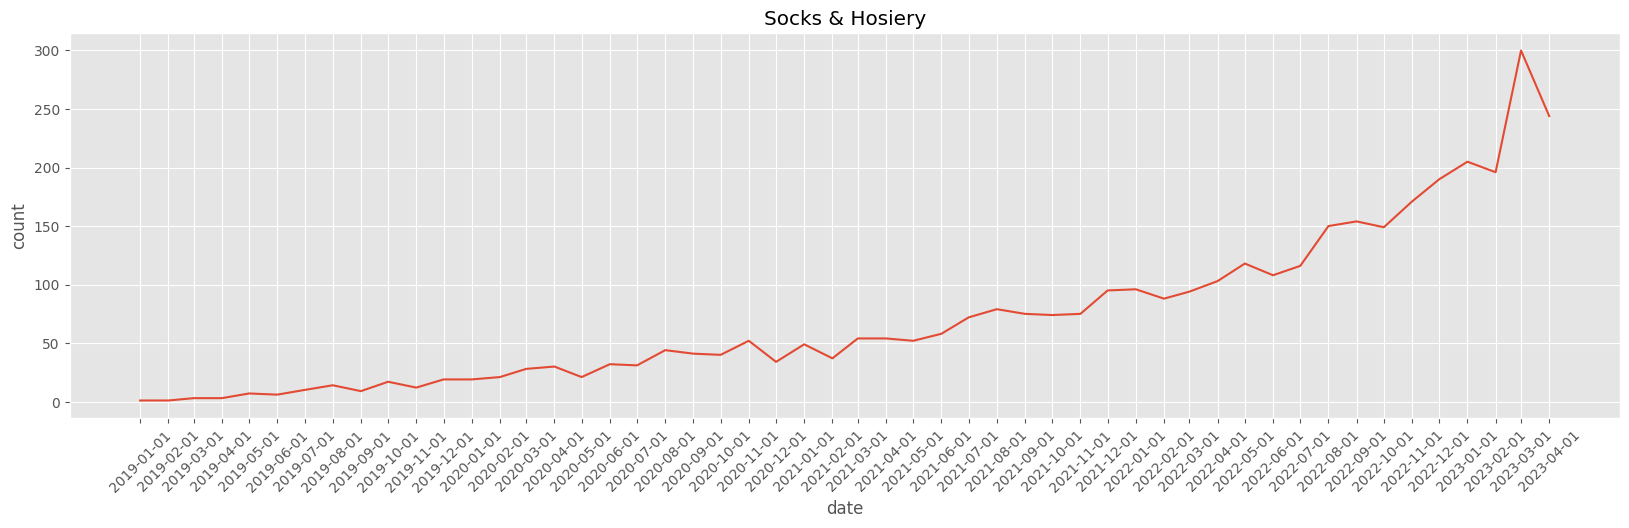

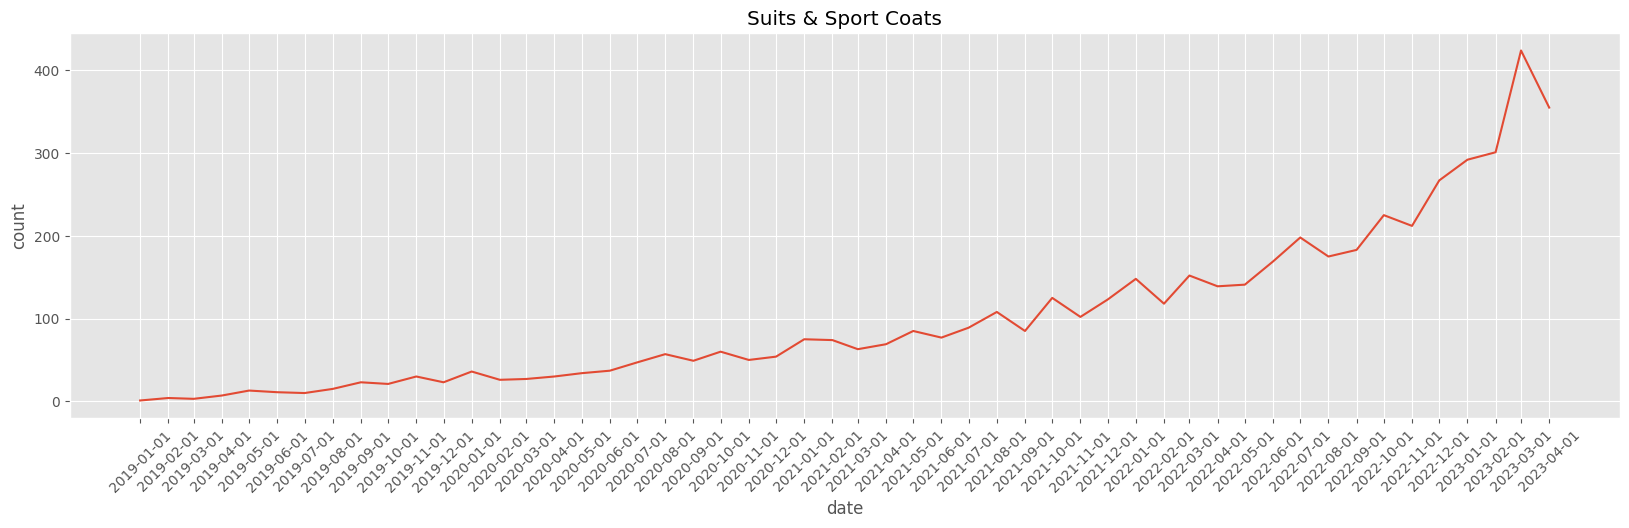

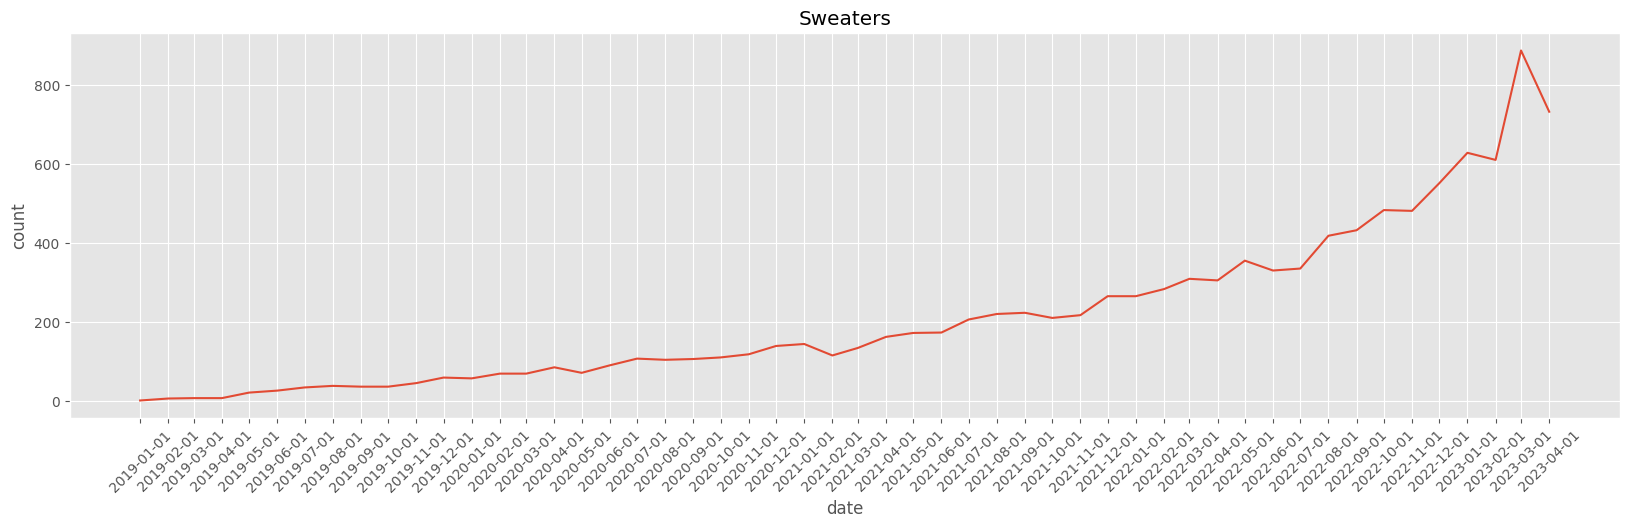

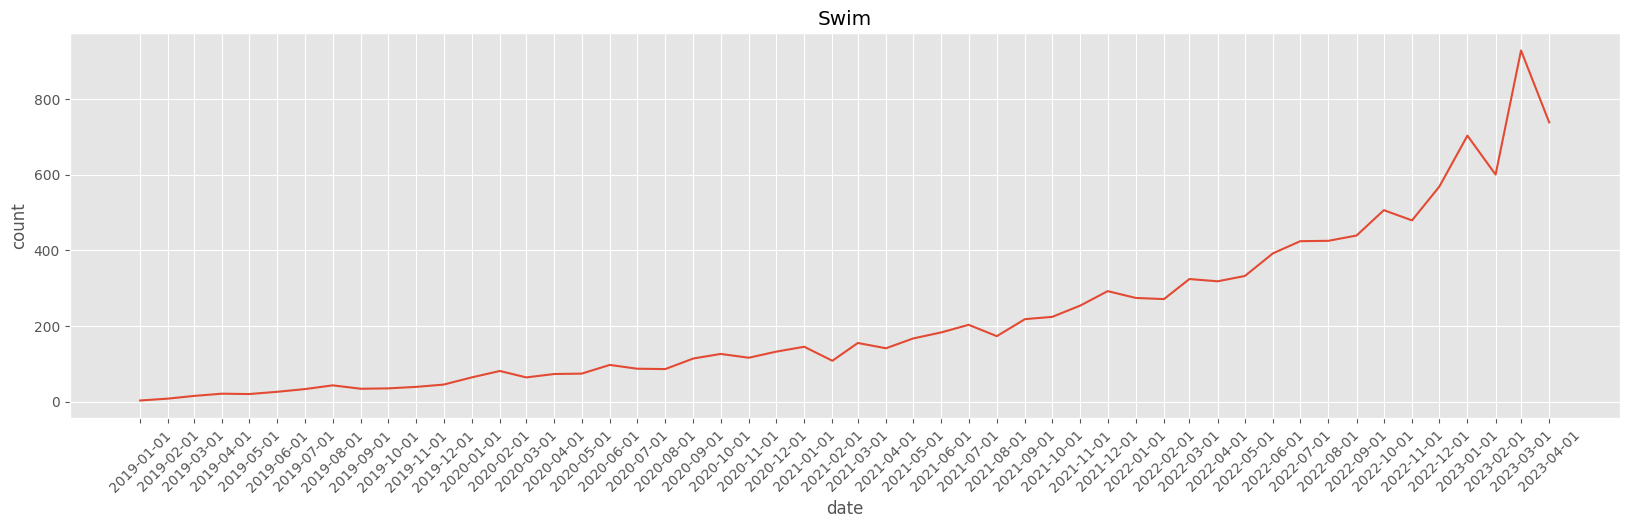

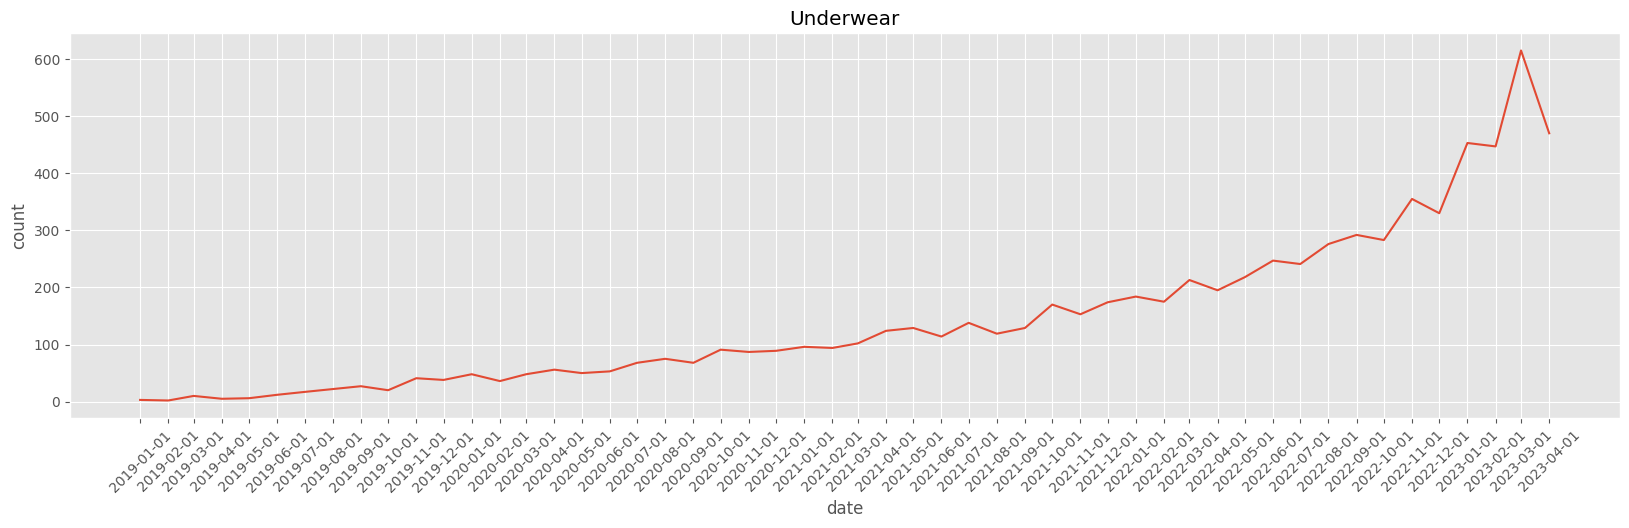

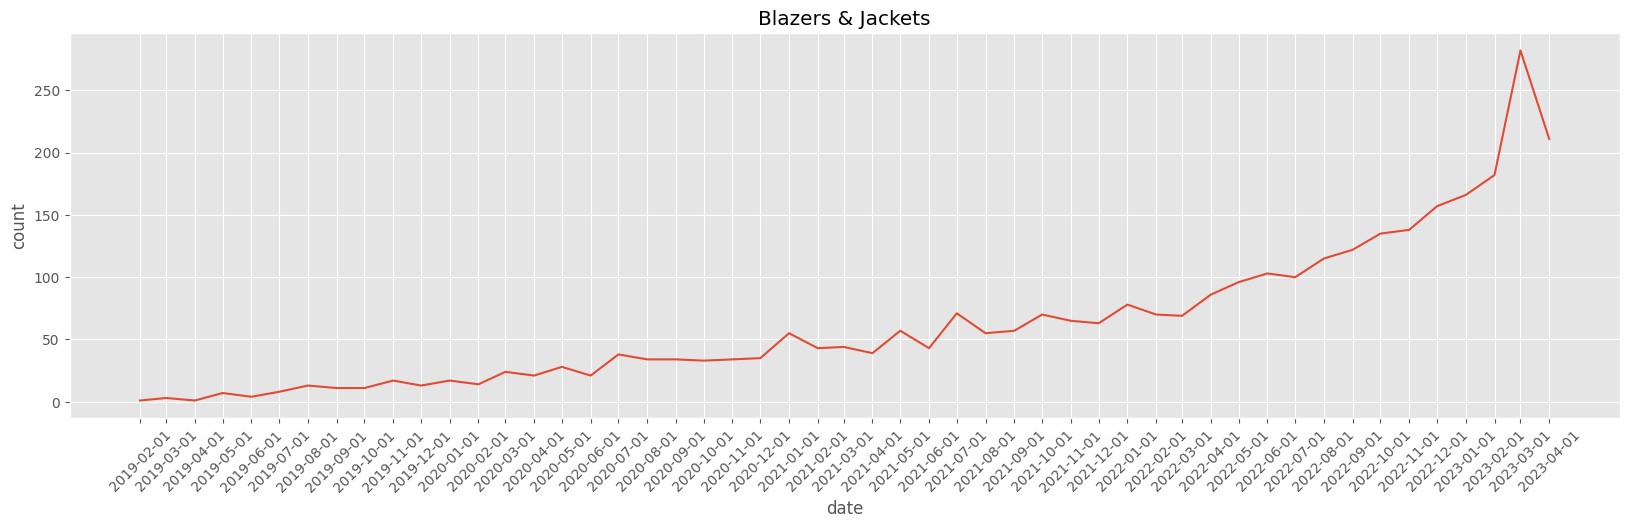

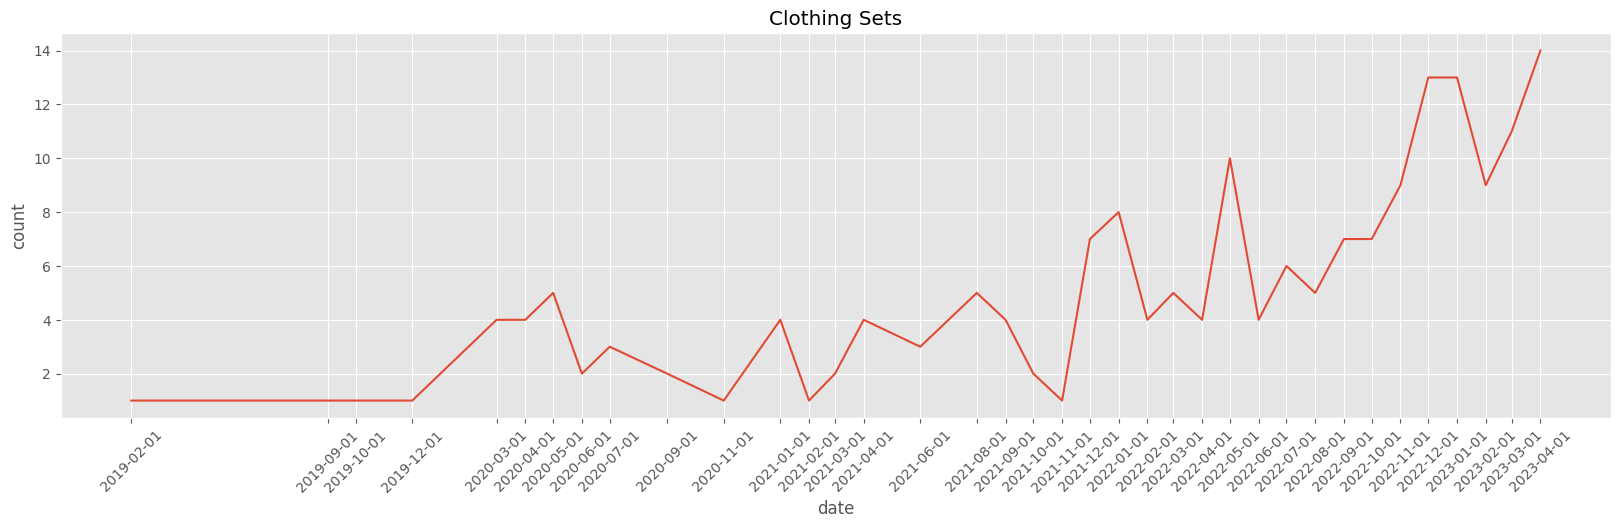

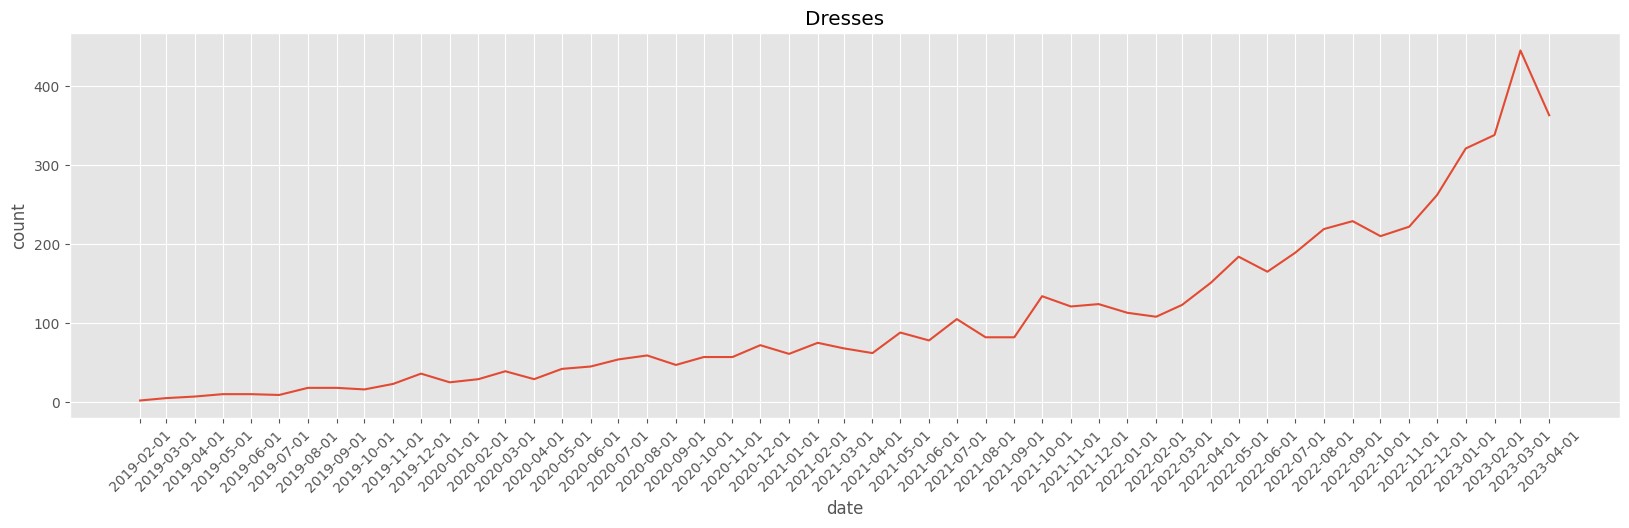

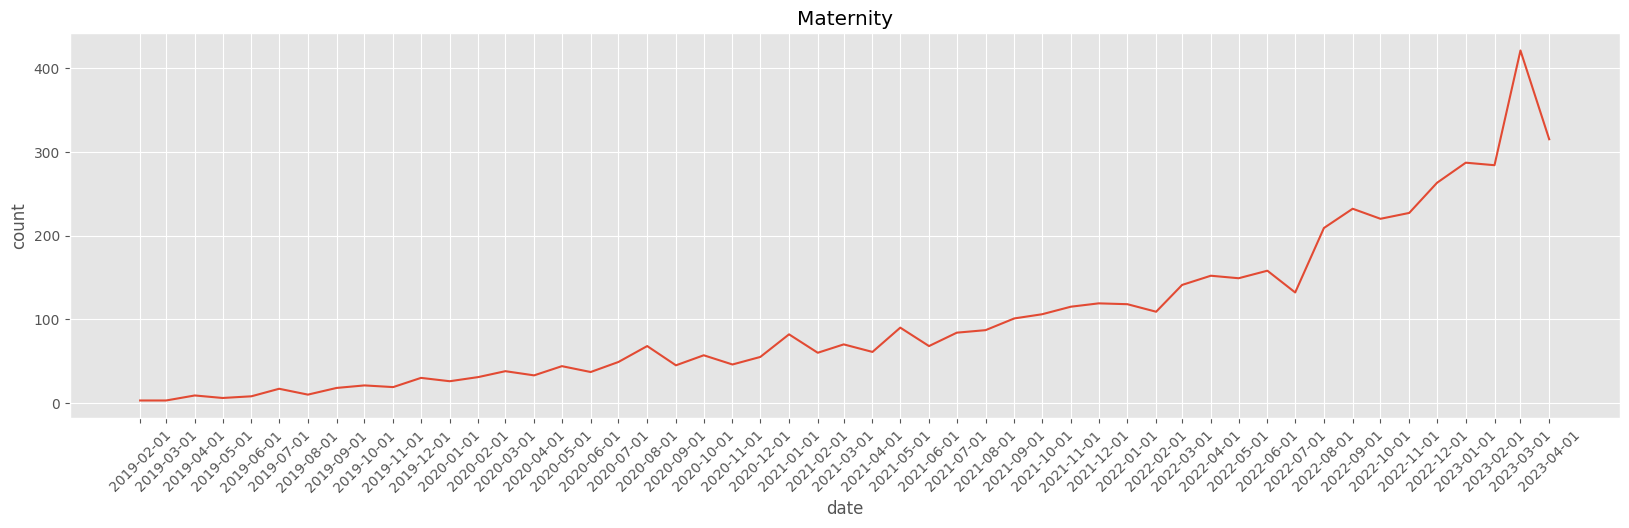

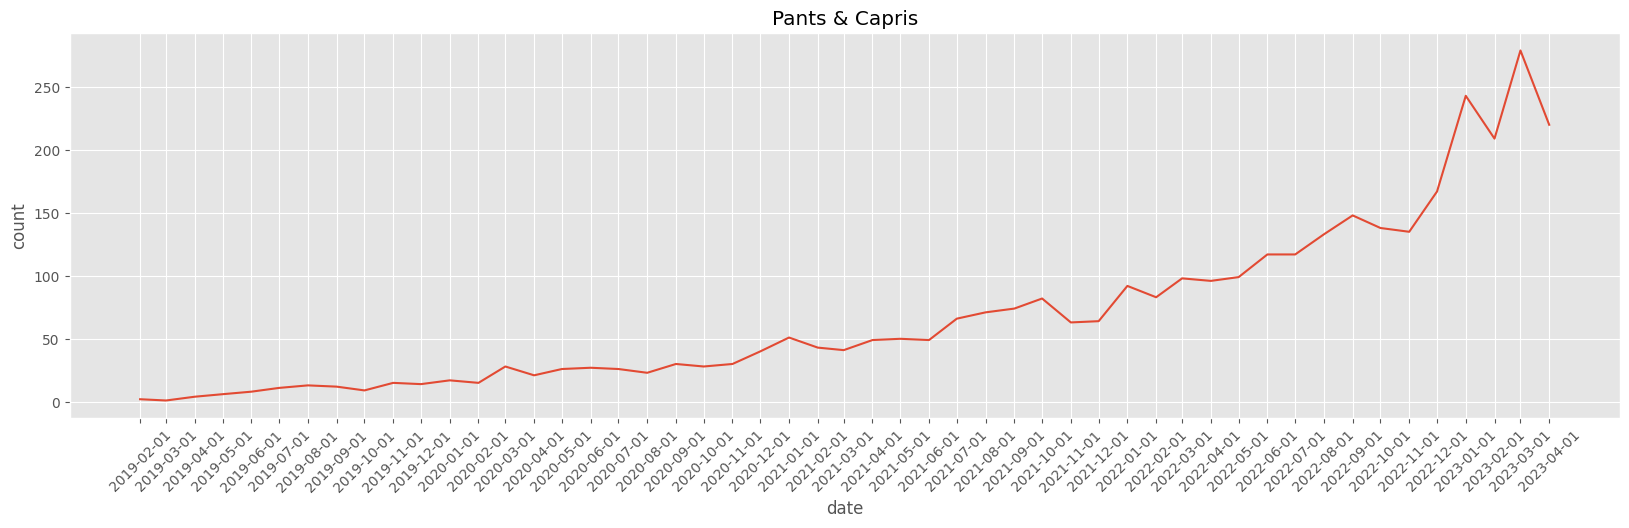

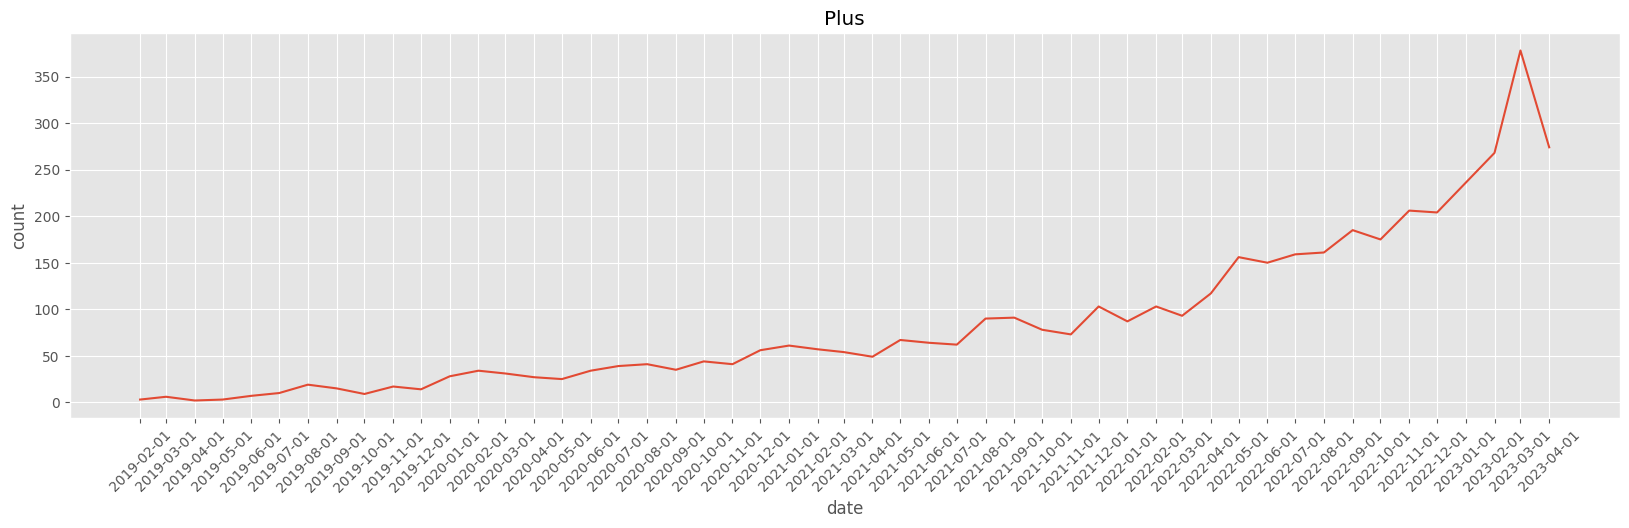

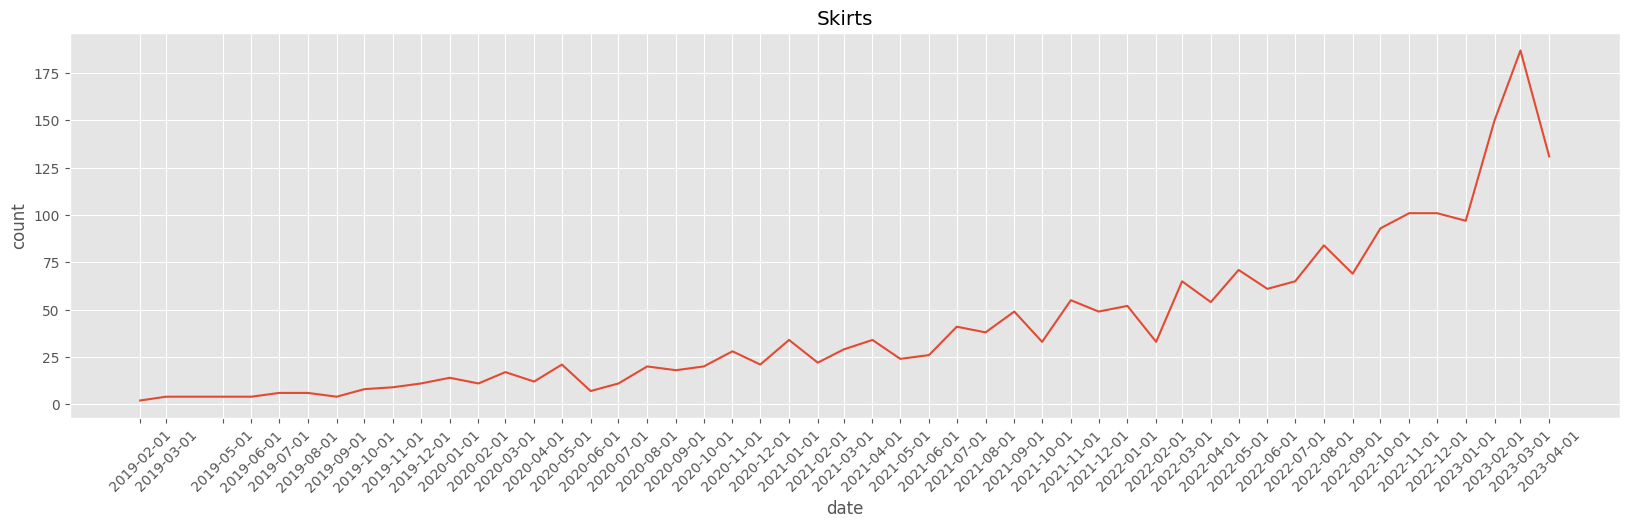

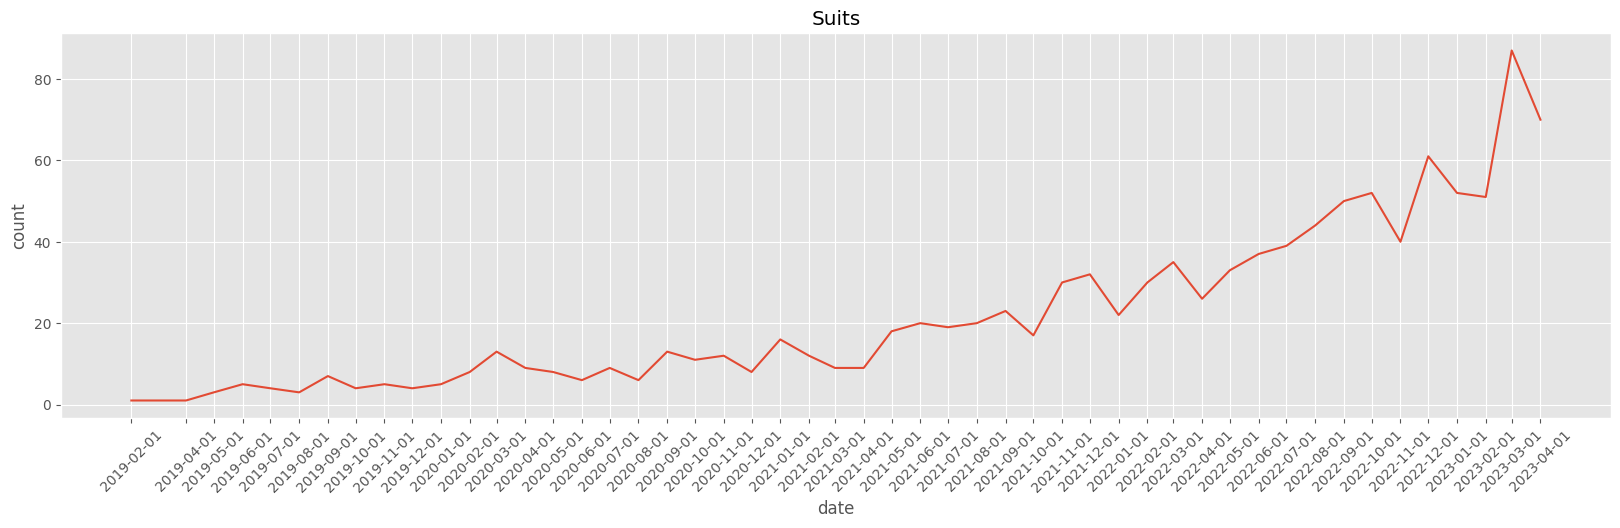

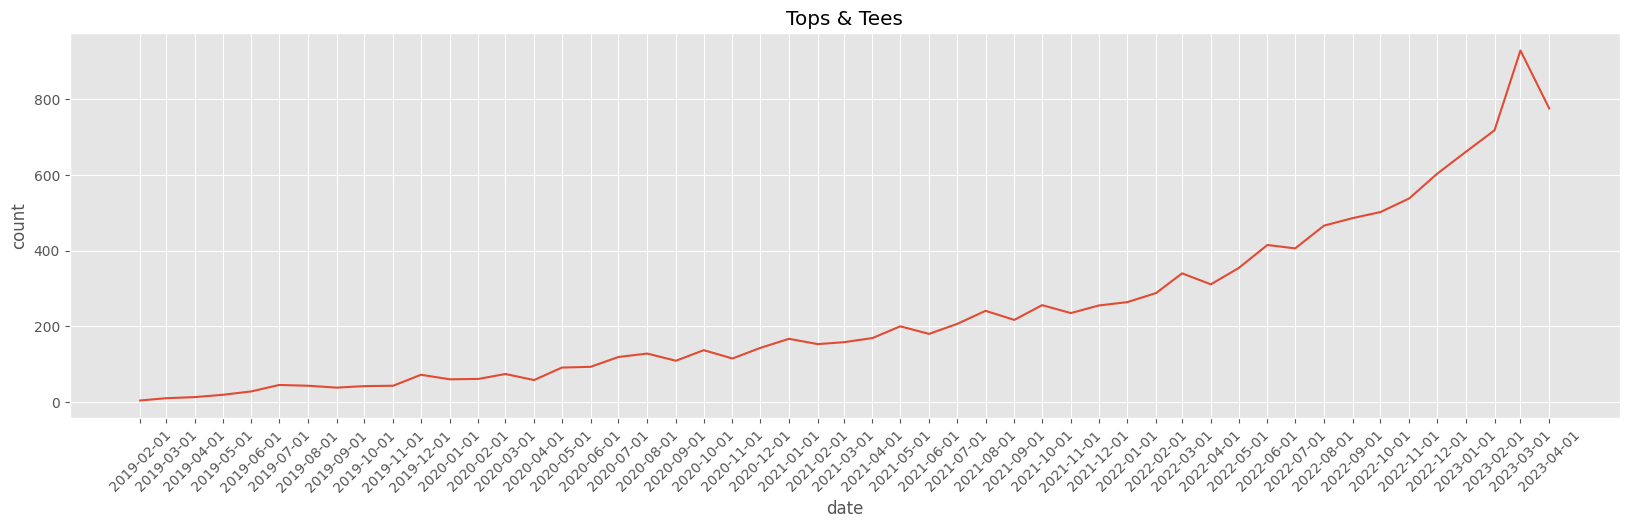

In [ ]:
# plot the line graph

plt.style.use('ggplot')
for category in count_productcat['product_category'].unique():
    plt.subplots(figsize=(20, 5))
    count_productcat_category = count_productcat[count_productcat['product_category'] == category]
    dates = [pd.to_datetime(date) for date in count_productcat_category['date']]
    sns.lineplot(data=count_productcat_category, x='date', y='count')
    plt.xticks(dates, rotation = 45)
    plt.title(category)
    plt.show()

# Machine Learning Start

In [4]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import xgboost as xgb

In [5]:
#order_items_product.to_csv('order_items_product.csv', index=False)

order_items_product = pd.read_csv('order_items_product.csv')

In [6]:
order_items_product.head()

,id_x,order_id,user_id,product_id_x,inventory_item_id,status,created_at_x,shipped_at,delivered_at,returned_at,...,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id,year,month,day
0,82431,56667,45224,13606,222767,Returned,2022-08-07 06:27:15+00:00,2022-08-08 06:10:00 UTC,2022-08-12 12:50:00 UTC,2022-08-13 19:51:00 UTC,...,Accessories,Elegant PASHMINA SCARF WRAP SHAWL STOLE,Scarf_tradinginc,2.5,Women,4ACBEDBE977480D19B7B682D4878CAE2,3,2022,8,7
1,76930,52883,42129,28951,207892,Shipped,2022-12-31 05:59:28+00:00,2022-12-31 00:13:00 UTC,NaN,NaN,...,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades,3.0,Men,110EED2C630AAB0F3FA87D6473926732,6,2022,12,31
2,89108,61208,48840,28951,240867,Shipped,2023-04-09 06:04:44.587835+00:00,2023-04-11 17:55:32.587835 UTC,NaN,NaN,...,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades,3.0,Men,110EED2C630AAB0F3FA87D6473926732,6,2023,4,9
3,99397,68296,54601,28951,268466,Shipped,2021-02-28 07:41:21+00:00,2021-02-28 17:23:00 UTC,NaN,NaN,...,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades,3.0,Men,110EED2C630AAB0F3FA87D6473926732,6,2021,2,28
4,174435,120100,96013,28951,470910,Shipped,2023-02-22 10:49:33+00:00,2023-02-25 05:31:00 UTC,NaN,NaN,...,Accessories,Nice Shades Black One Size Canvas Military Web...,Nice Shades,3.0,Men,110EED2C630AAB0F3FA87D6473926732,6,2023,2,22


In [7]:
# Cleaning the dataset by dropping unnecessary columns

order_items_product.columns

Index(['id_x', 'order_id', 'user_id', 'product_id_x', 'inventory_item_id',
       'status', 'created_at_x', 'shipped_at', 'delivered_at', 'returned_at',
       'sale_price', 'id_y', 'product_id_y', 'created_at_y', 'sold_at', 'cost',
       'product_category', 'product_name', 'product_brand',
       'product_retail_price', 'product_department', 'product_sku',
       'product_distribution_center_id', 'year', 'month', 'day'],
      dtype='object')

In [8]:
df = order_items_product[['created_at_x',
                          'product_category', 
                          'product_brand',
                          'product_distribution_center_id', 
                          'year', 'month', 'day', 'product_retail_price']].copy()

In [9]:
df

,created_at_x,product_category,product_brand,product_distribution_center_id,year,month,day,product_retail_price
0,2022-08-07 06:27:15+00:00,Accessories,Scarf_tradinginc,3,2022,8,7,2.50
1,2022-12-31 05:59:28+00:00,Accessories,Nice Shades,6,2022,12,31,3.00
2,2023-04-09 06:04:44.587835+00:00,Accessories,Nice Shades,6,2023,4,9,3.00
3,2021-02-28 07:41:21+00:00,Accessories,Nice Shades,6,2021,2,28,3.00
4,2023-02-22 10:49:33+00:00,Accessories,Nice Shades,6,2023,2,22,3.00
...,...,...,...,...,...,...,...,...
181617,2022-11-15 00:24:26+00:00,Dresses,Allegra K,9,2022,11,15,9.82
181618,2022-08-18 12:06:08+00:00,Dresses,Allegra K,9,2022,8,18,9.82
181619,2021-07-21 07:41:03+00:00,Dresses,Allegra K,9,2021,7,21,9.82
181620,2021-11-09 03:32:33+00:00,Dresses,Allegra K,9,2021,11,9,9.82


In [ ]:
train = df.loc[(df['created_at_x'] < '2022-09-01 00:00:00') ].copy()
test = df.loc[ (df['created_at_x'] >= '2022-09-01 00:00:00') ].copy()

In [ ]:
print(df.shape)
print(train.shape)
print(test.shape)

(181622, 8)
(102793, 8)
(78829, 8)


In [ ]:
train = train.groupby(['year', 'month', 'product_distribution_center_id','product_category','product_brand','product_retail_price' ]).size().reset_index(name='count')
train = train.sort_values(by = ['year', 'month', 'product_distribution_center_id','product_category','product_brand','product_retail_price'])

In [ ]:
train

,year,month,product_distribution_center_id,product_category,product_brand,product_retail_price,count
0,2019,1,1,Jeans,Silver Jeans,95.000000,1
1,2019,1,1,Socks,FootJoy,13.950000,1
2,2019,1,2,Active,Danskin,27.219999,1
3,2019,1,2,Leggings,SK Hat shop,14.950000,1
4,2019,1,2,Socks & Hosiery,SK Hat shop,10.950000,1
...,...,...,...,...,...,...,...
88604,2022,8,10,Underwear,Papi,23.000000,1
88605,2022,8,10,Underwear,Papi,24.000000,1
88606,2022,8,10,Underwear,Papi,25.000000,1
88607,2022,8,10,Underwear,Papi,30.000000,1


In [ ]:
test = test.groupby(['year', 'month', 'product_distribution_center_id','product_category','product_brand','product_retail_price' ]).size().reset_index(name='count')
test = test.sort_values(by = ['year', 'month', 'product_distribution_center_id','product_category','product_brand','product_retail_price'])

In [ ]:
test

,year,month,product_distribution_center_id,product_category,product_brand,product_retail_price,count
0,2022,9,1,Accessories,ASICS,22.000000,1
1,2022,9,1,Accessories,Belts.com,9.990000,1
2,2022,9,1,Accessories,Broner,29.950001,1
3,2022,9,1,Accessories,C.C. Exclusives,13.990000,1
4,2022,9,1,Accessories,Cashmere Boutique,35.000000,1
...,...,...,...,...,...,...,...
55506,2023,4,10,Underwear,Papi,24.000000,4
55507,2023,4,10,Underwear,Papi,25.000000,4
55508,2023,4,10,Underwear,Papi,28.000000,1
55509,2023,4,10,Underwear,Ralph Lauren,37.990002,1


# Testing XGboost regressor without feature engineering

In [ ]:
train_x = train.iloc[:,:-1].copy()
train_y = pd.DataFrame(train.iloc[:,-1]).copy()

print('Shape of train X ', train_x.shape)
print('Shape of train Y ', train_y.shape)

Shape of train X  (88609, 6)
Shape of train Y  (88609, 1)


In [ ]:
test_x = test.iloc[:,:-1].copy()
test_y = pd.DataFrame(test.iloc[:,-1]).copy()

print('Shape of test X ', test_x.shape)
print('Shape of test Y ', test_y.shape)

Shape of test X  (55511, 6)
Shape of test Y  (55511, 1)


In [ ]:
cat_cols = [i for i in train_x.select_dtypes(include=['object']).columns]
print('Categorical columns ---->>> ',cat_cols)

num_cols = [i for i in train_x.select_dtypes(include=['int64','float']).columns]
print('Numerical columns ---->>> ',num_cols)

Categorical columns ---->>>  ['product_category', 'product_brand']
Numerical columns ---->>>  ['year', 'month', 'product_distribution_center_id', 'product_retail_price']


In [ ]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('std_scaler', StandardScaler()),
                         ])

preprocessor = ColumnTransformer(
    transformers=[('num', num_pipeline, num_cols),
                  ('encoder', OneHotEncoder(handle_unknown="ignore"), 
                   cat_cols) ])

pipe = Pipeline([('preprocessor', preprocessor), 
                 ('xgboost', XGBRegressor())])

pipe.fit(train_x, train_y)

test_preds = np.rint(pipe.predict(test_x))
    
rmse = mean_squared_error(test_y, test_preds)

In [ ]:
print('RMSE', rmse)

RMSE 0.9112608311866116


In [ ]:
from sklearn.metrics import r2_score

# assuming y_true and y_pred are your true and predicted target values, respectively
r2 = r2_score(test_y,test_preds)
print("R-squared score:", r2)


R-squared score: -0.04732933769009584


In [ ]:
pred_df = test.copy()
pred_df['prediction'] = test_preds

In [ ]:
pred_df.head()

,year,month,product_distribution_center_id,product_category,product_brand,product_retail_price,count,prediction
0,2022,9,1,Accessories,ASICS,22.000000,1,1.0
1,2022,9,1,Accessories,Belts.com,9.990000,1,1.0
2,2022,9,1,Accessories,Broner,29.950001,1,1.0
3,2022,9,1,Accessories,C.C. Exclusives,13.990000,1,1.0
4,2022,9,1,Accessories,Cashmere Boutique,35.000000,1,1.0


In [ ]:
pred_df['difference'] = pred_df['count'] - pred_df['prediction']

pred_df['date'] = pd.to_datetime(pred_df['year'].astype(str) + '-' + pred_df['month'].astype(str), format='%Y-%m')

pred_df.to_csv('pred_df.csv', index=False, )

In [ ]:
pred_df.head()

,year,month,product_distribution_center_id,product_category,product_brand,product_retail_price,count,prediction,difference,date
0,2022,9,1,Accessories,ASICS,22.000000,1,1.0,0.0,2022-09-01
1,2022,9,1,Accessories,Belts.com,9.990000,1,1.0,0.0,2022-09-01
2,2022,9,1,Accessories,Broner,29.950001,1,1.0,0.0,2022-09-01
3,2022,9,1,Accessories,C.C. Exclusives,13.990000,1,1.0,0.0,2022-09-01
4,2022,9,1,Accessories,Cashmere Boutique,35.000000,1,1.0,0.0,2022-09-01


# Feature engineering

In [ ]:
!pip install holidays

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import holidays
us_holidays = holidays.US()

In [ ]:
dates = []
names = []
for date, name in sorted(holidays.US(subdiv = 'MA', years=[2019,2020,2021,2022,2023]).items()):
    dates.append(str(date))
    names.append(name)

holidays_df  = pd.DataFrame({
    'date': dates,
    'holiday': names
})

In [ ]:
holidays_df.head()

,date,holiday
0,2019-01-01,New Year's Day
1,2019-01-21,Martin Luther King Jr. Day
2,2019-02-18,Washington's Birthday
3,2019-03-17,Evacuation Day
4,2019-03-18,Evacuation Day (Observed)


In [ ]:
train = df.loc[(df['created_at_x'] < '2022-09-01 00:00:00') ].copy()
test = df.loc[ (df['created_at_x'] >= '2022-09-01 00:00:00') ].copy()

In [ ]:
train['date'] = pd.to_datetime(train['year'].astype(str) + '-' + train['month'].astype(str) + '-' + train['day'].astype(str), format='%Y-%m-%d')
test['date'] = pd.to_datetime(test['year'].astype(str) + '-' + test['month'].astype(str) + '-' + test['day'].astype(str), format='%Y-%m-%d')

train = train.sort_values(by = ['date'])
test = test.sort_values(by = ['date'])

In [ ]:
# Convert the date columns to datetime format
train['date'] = pd.to_datetime(train['date'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

# Merge the two dataframes based on the date column
train = pd.merge_asof(train, holidays_df, on='date', direction='forward')



In [ ]:
test['date'] = pd.to_datetime(test['date'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

# Merge the two dataframes based on the date column
test = pd.merge_asof(test, holidays_df, on='date', direction='forward')


In [ ]:
def get_season(date_str):
    date = pd.to_datetime(date_str, format='%Y-%m-%d')
    year = str(date.year)
    seasons = {
        'winter': pd.date_range(start=year+'/01/01', end=year +'/03/19'),
        'spring': pd.date_range(start=year+'/03/20', end=year+'/06/20'),
        'summer': pd.date_range(start=year+'/06/21', end=year+'/09/21'),
        'autumn': pd.date_range(start=year+'/09/22', end=year+'/12/20')
    }
    if date in seasons['winter']:
        return 'winter'
    elif date in seasons['spring']:
        return 'spring'
    elif date in seasons['summer']:
        return 'summer'
    elif date in seasons['autumn']:
        return 'autumn'
    else:
      return 'Winter'


In [ ]:
train['season'] = train['date'].apply(get_season)
test['season'] = test['date'].apply(get_season)

In [ ]:
#Store as a backup dataframe to avoid code rerun while testing the notebook

train_df = train.copy()
test_df = test.copy()

In [ ]:
#train = train_df.copy()
#test = test_df.copy()

In [ ]:
train = train.drop('created_at_x', axis=1).copy()


In [ ]:
test = test.drop('created_at_x', axis=1).copy()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102793 entries, 0 to 102792
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   product_category                102793 non-null  object        
 1   product_brand                   102706 non-null  object        
 2   product_distribution_center_id  102793 non-null  int64         
 3   year                            102793 non-null  int64         
 4   month                           102793 non-null  int64         
 5   day                             102793 non-null  int64         
 6   product_retail_price            102793 non-null  float64       
 7   date                            102793 non-null  datetime64[ns]
 8   holiday                         102793 non-null  object        
 9   season                          102793 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
me

In [ ]:
train.head()

,product_category,product_brand,product_distribution_center_id,year,month,day,product_retail_price,date,holiday,season
0,Jeans,Silver Jeans,1,2019,1,6,95.000000,2019-01-06,Martin Luther King Jr. Day,winter
1,Accessories,Carhartt,3,2019,1,6,18.950001,2019-01-06,Martin Luther King Jr. Day,winter
2,Outerwear & Coats,London Fog,7,2019,1,7,199.990005,2019-01-07,Martin Luther King Jr. Day,winter
3,Outerwear & Coats,Kenneth Cole,6,2019,1,9,109.989998,2019-01-09,Martin Luther King Jr. Day,winter
4,Shorts,Allegra K,9,2019,1,10,12.260000,2019-01-10,Martin Luther King Jr. Day,winter


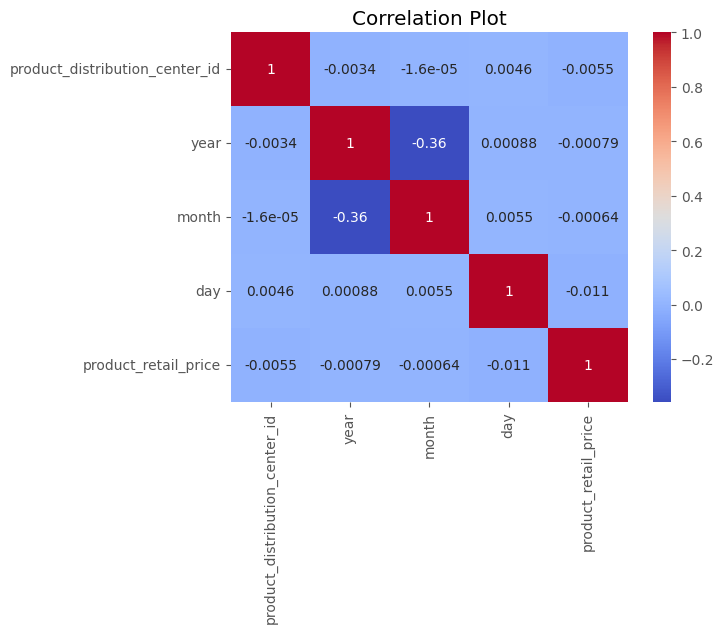

In [ ]:
# compute correlation matrix
corr = train.corr()

# plot correlation matrix as heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Plot')
plt.show()

In [ ]:
grouping_cols = ['year',
                 'season',
                 'month',
                 'holiday',
                 'product_category', 
                 'product_distribution_center_id',
                 'product_retail_price']

In [ ]:
train = train.groupby(grouping_cols).size().reset_index(name='count')
train = train.sort_values(by = grouping_cols)

In [ ]:
test = test.groupby(grouping_cols).size().reset_index(name='count')
test = test.sort_values(by = grouping_cols)

In [ ]:
train_x = train.iloc[:,:-1].copy()
train_y = pd.DataFrame(train.iloc[:,-1]).copy()

print('Shape of train X ', train_x.shape)
print('Shape of train Y ', train_y.shape)

Shape of train X  (90517, 7)
Shape of train Y  (90517, 1)


In [ ]:
test_x = test.iloc[:,:-1].copy()
test_y = pd.DataFrame(test.iloc[:,-1]).copy()

print('Shape of test X ', test_x.shape)
print('Shape of test Y ', test_y.shape)

Shape of test X  (60519, 7)
Shape of test Y  (60519, 1)


In [ ]:
cat_cols = [i for i in train_x.select_dtypes(include=['object']).columns]
print('Categorical columns ---->>> ',cat_cols)

num_cols = [i for i in train_x.select_dtypes(include=['int64','float64','UInt32']).columns]
print('Numerical columns ---->>> ',num_cols)

Categorical columns ---->>>  ['season', 'holiday', 'product_category']
Numerical columns ---->>>  ['year', 'month', 'product_distribution_center_id', 'product_retail_price']


In [ ]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('std_scaler', StandardScaler()),
                         ])

preprocessor = ColumnTransformer(
    transformers=[('num', num_pipeline, num_cols),
                  ('encoder', OneHotEncoder(handle_unknown="ignore"), 
                   cat_cols) ])

pipe = Pipeline([('preprocessor', preprocessor), 
                 ('xgboost', XGBRegressor(base_score=1, booster='gbtree',    
                           n_estimators=500,
                           objective='reg:squarederror',
                           max_depth=5,
                           learning_rate=0.01))])

pipe.fit(train_x, train_y)

test_preds = np.rint(pipe.predict(test_x))
    
rmse = mean_squared_error(test_y, test_preds)

In [ ]:
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 0.673606635932517


In [ ]:
from sklearn.metrics import mean_absolute_error

# Assuming y_true and y_pred are your true and predicted target values respectively
mae = mean_absolute_error(test_y, test_preds)

print("Mean Absolute Error:", mae)



Mean Absolute Error: 0.3064822617690312


In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(test_y, test_preds)
print("R2 score:", r2)

R2 score: -0.10945048861738793


In [ ]:
pred_df = test.copy()
pred_df['prediction'] = test_preds

In [ ]:
pred_df['difference'] = pred_df['count'] - pred_df['prediction']

pred_df['date'] = pd.to_datetime(pred_df['year'].astype(str) + '-' + pred_df['month'].astype(str), format='%Y-%m')

pred_df.to_csv('pred_df.csv', index=False, )

# Checking for why such low R2 score

In [ ]:
train.head()

,year,season,month,holiday,product_category,product_distribution_center_id,product_retail_price,count
0,2019,Winter,12,Christmas Day,Accessories,2,70.000000,1
1,2019,Winter,12,Christmas Day,Accessories,5,50.000000,1
2,2019,Winter,12,Christmas Day,Accessories,7,17.950001,1
3,2019,Winter,12,Christmas Day,Accessories,8,83.559998,1
4,2019,Winter,12,Christmas Day,Accessories,8,182.220001,1


In [ ]:
train['date'] =pd.to_datetime(train['year'].astype(str) + '-' + train['month'].astype(str), format='%Y-%m')
test['date'] = pd.to_datetime(test['year'].astype(str) + '-' + test['month'].astype(str), format='%Y-%m')

In [ ]:
plot_train = train[['date','count']].copy()

In [ ]:
plot_test = test[['date','count']].copy()

In [ ]:
plot_train = plot_train.groupby('date')['count'].sum()


In [ ]:
plot_test = plot_test.groupby('date')['count'].sum()

In [ ]:
#plot_test = plot_test.set_index('date')

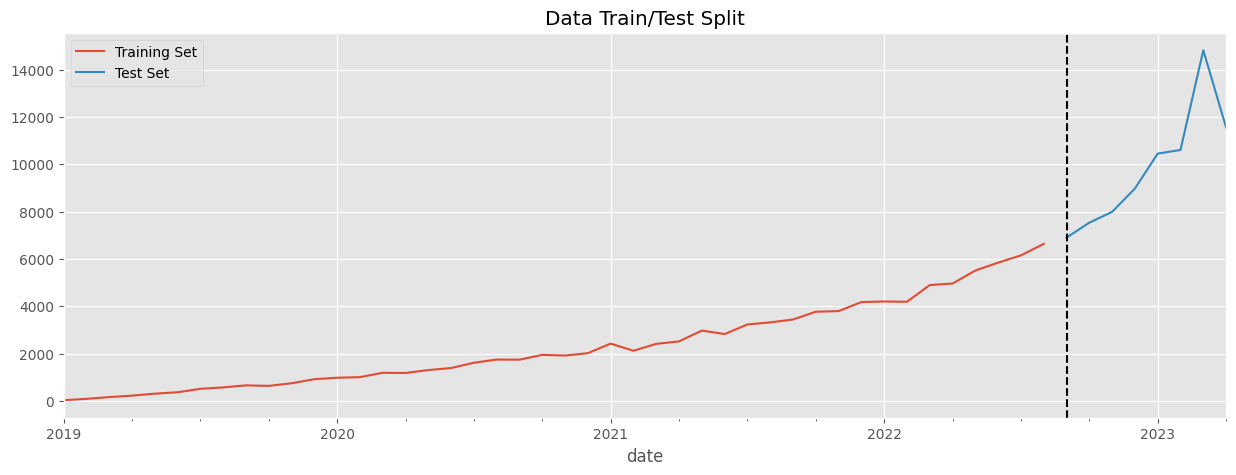

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
plot_train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
plot_test.plot(ax=ax, label='Test Set')
ax.axvline('2022-09-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

Due to lack of cross validation model is only training on the data before Sept of 2022, and since the trend is not stationary and increasing the model is performing well on the RMSE, MAE metrics but fails on R2 metric as the model makes considerable mistakes while predicting values for high frequency purchased items to handle this issue we will use K-fold validation and check the model performance.

# Time Series Cross Validation

In [10]:
df_cv = df.copy()

In [11]:
df_cv['date'] = pd.to_datetime(df_cv['year'].astype(str) + '-' + df_cv['month'].astype(str) + '-' + df_cv['day'].astype(str), format='%Y-%m-%d')

In [12]:
df_cv = df_cv.set_index('date')

In [13]:
df_cv = df_cv.drop('created_at_x', axis=1)

In [14]:
df_cv = df_cv.sort_index()

In [15]:
grouping_cols = ['year',
                 'month',
                 'product_distribution_center_id',
                 'product_category']

In [16]:
df_cv = df_cv.groupby(grouping_cols).size().reset_index(name='count')
df_cv = df_cv.sort_values(by = grouping_cols)

In [17]:
df_cv['date'] = pd.to_datetime(df_cv['year'].astype(str) + '-' + df_cv['month'].astype(str), format='%Y-%m-%d')

In [18]:
df_cv = df_cv.set_index('date')

In [19]:
df_cv = df_cv.sort_index()

In [20]:
from tqdm import tqdm

def add_lag(dfc):

  df = dfc.copy()

  df['lastmonth'] = 0
  df['last3month'] = 0
  df['last6month'] = 0 

  for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    
    lastmonth = (index - pd.Timedelta('30 days'))
    last3month = (index - pd.Timedelta('60 days'))
    last6month = (index - pd.Timedelta('90 days'))

    mask = ( (df['year'] == lastmonth.year) & (df['month'] == lastmonth.month) & (df['product_distribution_center_id'] == row['product_distribution_center_id']) & (df['product_category'] == row['product_category']) )
    mask3 =  ( (df['year'] == last3month.year) & (df['month'] == last3month.month) & (df['product_distribution_center_id'] == row['product_distribution_center_id']) & (df['product_category'] == row['product_category']) )
    mask6 = ( (df['year'] == last6month.year) & (df['month'] == last6month.month) & (df['product_distribution_center_id'] == row['product_distribution_center_id']) & (df['product_category'] == row['product_category']) )

    currentmask = ( (df['year'] == index.year) & (df['month'] == index.month) & (df['product_distribution_center_id'] == row['product_distribution_center_id']) & (df['product_category'] == row['product_category']) )
    #last month
    if df.loc[mask].shape[0] > 0:
      df.loc[currentmask, 'lastmonth'] = df.loc[mask, 'count'].values[0]

    #last3month
    if df.loc[mask3].shape[0] > 0:
      df.loc[currentmask, 'last3month'] = df.loc[mask3, 'count'].values[0]

    #last6month
    if df.loc[mask6].shape[0] > 0:
      df.loc[currentmask, 'last6month'] = df.loc[mask6, 'count'].values[0]

  return df



In [21]:
df_cv = add_lag(df_cv)

100%|██████████| 11451/11451 [01:48<00:00, 105.72it/s]


In [22]:
df_cv_without_index = df_cv.reset_index(level='date').copy()

In [23]:
df_cv_without_index = df_cv_without_index.drop('date', axis=1)

In [24]:
df_cv_without_index

,year,month,product_distribution_center_id,product_category,count,lastmonth,last3month,last6month
0,2019,1,1,Jeans,1,0,0,0
1,2019,1,1,Socks,1,0,0,0
2,2019,1,2,Active,1,0,0,0
3,2019,1,2,Leggings,1,0,0,0
4,2019,1,2,Socks & Hosiery,1,0,0,0
...,...,...,...,...,...,...,...,...
11446,2023,4,10,Suits & Sport Coats,29,31,26,26
11447,2023,4,10,Sweaters,28,31,28,28
11448,2023,4,10,Swim,31,47,23,23
11449,2023,4,10,Tops & Tees,41,44,30,30


We have two dataframe one with index as date and second with index resetted so that we will use first dataframe to run the timeseriessplit as it requires date column to be in the index can get the indices for the train and validation split this indices will be used to split our second dataframe so that we can run model without the actual date column

In [25]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=10)


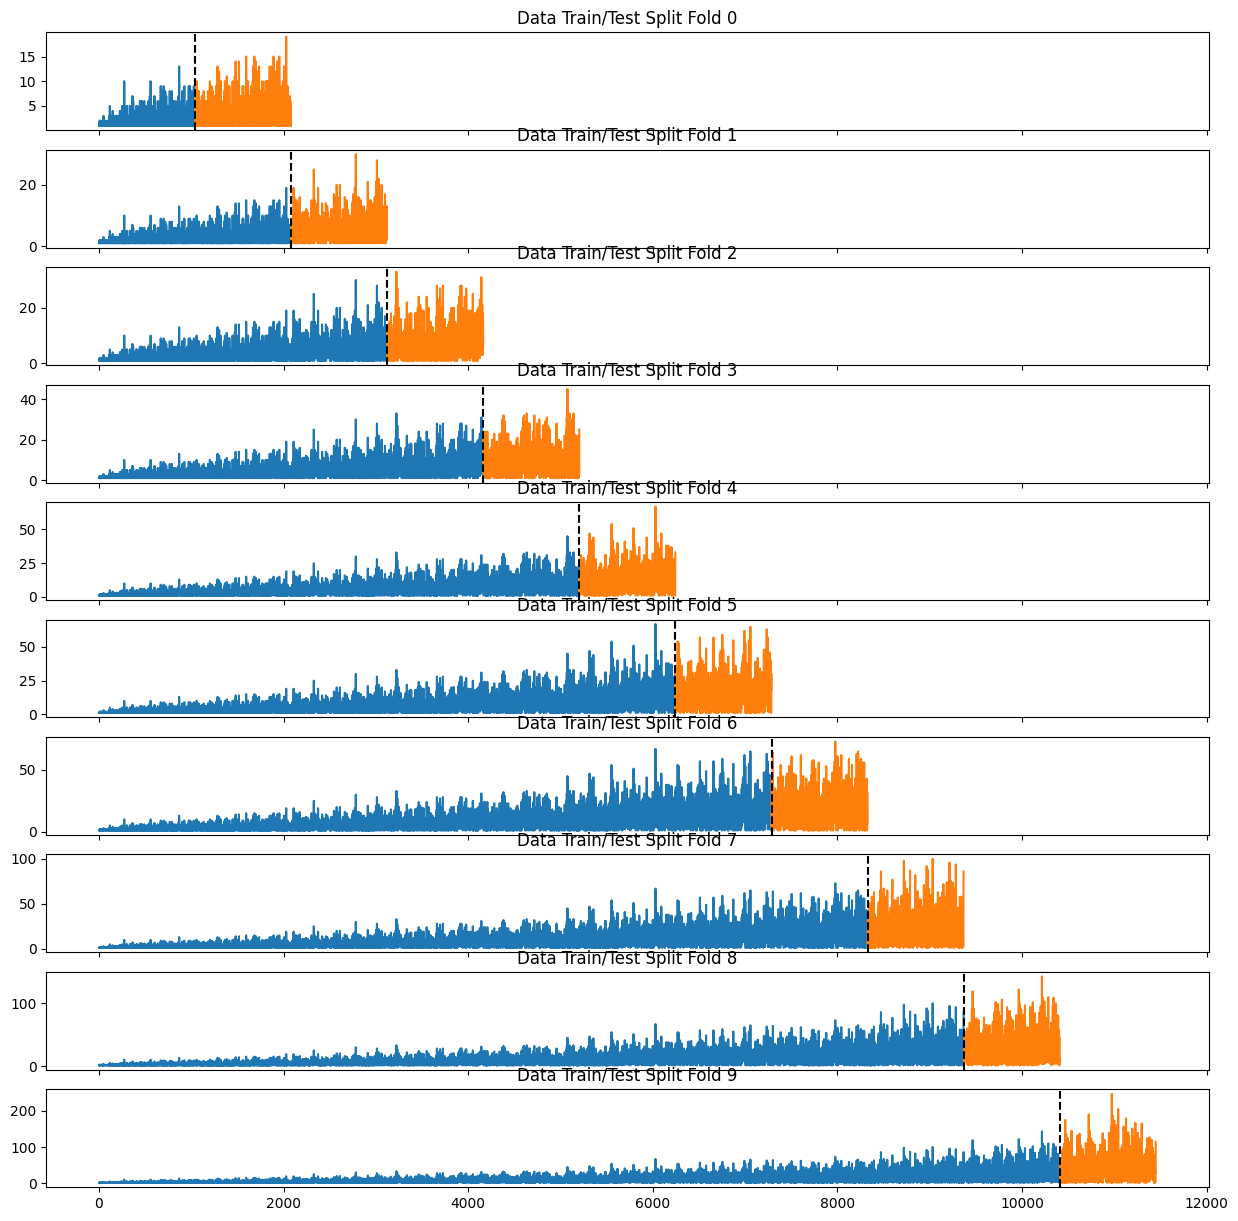

In [26]:
fig, axs = plt.subplots(10, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_cv):
    train = df_cv_without_index.iloc[train_idx]
    test = df_cv_without_index.iloc[val_idx]
    train['count'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['count'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [27]:

num_cols = [i for i in df_cv.select_dtypes(include=['int64','float64','UInt32']).columns]
num_cols.remove('count')
print('Numerical columns ---->>> ',num_cols)

Numerical columns ---->>>  ['year', 'month', 'product_distribution_center_id', 'lastmonth', 'last3month', 'last6month']


In [28]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def convert_categorical_to_numerical(df):
    """
    Converts all categorical columns in a pandas DataFrame to numerical values using Scikit-Learn's LabelEncoder.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The DataFrame containing categorical columns to be converted.
    
    Returns:
    --------
    pandas DataFrame
        The DataFrame with all categorical columns converted to numerical values.
    """
    le = LabelEncoder()
    df_new = df.copy()
    for column in df.select_dtypes(include=['object']):
        df_new[column] = le.fit_transform(df_new[column])
    
    return df_new


In [29]:
df_cv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11451 entries, 2019-01-01 to 2023-04-01
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   year                            11451 non-null  int64 
 1   month                           11451 non-null  int64 
 2   product_distribution_center_id  11451 non-null  int64 
 3   product_category                11451 non-null  object
 4   count                           11451 non-null  int64 
 5   lastmonth                       11451 non-null  int64 
 6   last3month                      11451 non-null  int64 
 7   last6month                      11451 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 805.1+ KB


In [30]:
fold = 0
preds = []
scores = []
scores_r = []

for train_idx, val_idx in tss.split(df_cv):
    train = df_cv.iloc[train_idx]
    test = df_cv.iloc[val_idx]

    train = train.reset_index(level='date').copy()
    train = train.drop('date', axis=1)

    test = test.reset_index(level='date').copy()
    test = test.drop('date', axis=1)

    FEATURES = ['product_category', 'year', 'month', 'product_distribution_center_id','lastmonth', 'last3month', 'last6month']
    TARGET = 'count'

    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]

    X_trainc = convert_categorical_to_numerical(X_train)

    X_testc = convert_categorical_to_numerical(X_test)


    reg = xgb.XGBRegressor(booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=5,
                           learning_rate=0.01)
    reg.fit(X_trainc, y_train,
            eval_set=[(X_trainc, y_train), (X_testc, y_test)],
            verbose=100)

    y_pred = np.rint( reg.predict(X_testc) )
    preds.append(y_pred)
    score = mean_squared_error(y_test, y_pred)
    score_r = r2_score(y_test, y_pred)
    scores.append(score)
    scores_r.append(score_r)


[0]	validation_0-rmse:2.42495	validation_1-rmse:4.27645
[100]	validation_0-rmse:1.49923	validation_1-rmse:3.06826
[200]	validation_0-rmse:1.25190	validation_1-rmse:2.78585
[300]	validation_0-rmse:1.16956	validation_1-rmse:2.72014
[400]	validation_0-rmse:1.13229	validation_1-rmse:2.70621
[411]	validation_0-rmse:1.12836	validation_1-rmse:2.70830
[0]	validation_0-rmse:3.47125	validation_1-rmse:6.43428
[100]	validation_0-rmse:2.02574	validation_1-rmse:3.76257
[200]	validation_0-rmse:1.64231	validation_1-rmse:3.06904
[300]	validation_0-rmse:1.52327	validation_1-rmse:2.92265
[400]	validation_0-rmse:1.46580	validation_1-rmse:2.90208
[474]	validation_0-rmse:1.43142	validation_1-rmse:2.90325
[0]	validation_0-rmse:4.66834	validation_1-rmse:9.00145
[100]	validation_0-rmse:2.55538	validation_1-rmse:4.88775
[200]	validation_0-rmse:2.01258	validation_1-rmse:3.71149
[300]	validation_0-rmse:1.87066	validation_1-rmse:3.44180
[400]	validation_0-rmse:1.81114	validation_1-rmse:3.38480
[500]	validation_0-r

In [31]:
print(f'Score across folds {np.mean(scores):0.2f}')
print(f'Fold scores:{scores}')

Score across folds 51.40
Fold scores:[7.413064361191163, 8.496637848222862, 11.523535062439962, 15.853986551392891, 21.443804034582133, 23.93852065321806, 32.46685878962536, 52.945244956772335, 56.976945244956774, 282.94140249759846]


In [32]:
print(f'Score across folds {np.mean(scores_r):0.1f}')
print(f'Fold scores_r:{scores_r}')

Score across folds 0.7
Fold scores_r:[0.07870189743854394, 0.498134337306844, 0.6258295573722462, 0.6612099519496751, 0.7448893264009122, 0.8187007745660062, 0.8267205513072868, 0.8401385891985497, 0.8977417593066397, 0.7905343570720516]


### Now that after featuring engineering and performing cross validation on the model the model is achieving RMSE score of 51.40 and R2 score of 0.7 which means our model is able to explain 70% of the variance in the data looking at these metrics we can have a 10% tolerance in the forecast predictions made by the model which is acceptable to push model into the production.

# Forecasting 

In [33]:
df_cv.head()

,year,month,product_distribution_center_id,product_category,count,lastmonth,last3month,last6month
date,,,,,,,,
2019-01-01,2019,1,1,Jeans,1,0,0,0
2019-01-01,2019,1,1,Socks,1,0,0,0
2019-01-01,2019,1,2,Active,1,0,0,0
2019-01-01,2019,1,2,Leggings,1,0,0,0
2019-01-01,2019,1,2,Socks & Hosiery,1,0,0,0


In [123]:
# Retrain on all data

FEATURES = ['year', 'month', 'product_distribution_center_id', 'product_category', 'lastmonth', 'last3month', 'last6month']

TARGET = 'count'

X_all = df_cv[FEATURES]
y_all = df_cv[TARGET]

X_all = convert_categorical_to_numerical(X_all)

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=600,
                       objective='reg:linear',
                       max_depth=5,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[21:10:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:25.21362
[100]	validation_0-rmse:10.59562
[200]	validation_0-rmse:5.98813
[300]	validation_0-rmse:4.85169
[400]	validation_0-rmse:4.56803
[500]	validation_0-rmse:4.45058
[599]	validation_0-rmse:4.38927


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=600, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

# Making dataframe for Future predictions

In [105]:
def add_lag_future(df_hist, df_fut):

  df_hist = df_hist.copy()
  df_fut = df_fut.copy()

  df_fut['lastmonth'] = 0
  df_fut['last3month'] = 0
  df_fut['last6month'] = 0 
  date = pd.to_datetime(df_fut['year'][0].astype(str) + '-' + df_fut['month'][0].astype(str), format='%Y-%m')
 
  
  lastmonth = (date - pd.Timedelta('30 days'))
  last3month = (date - pd.Timedelta('60 days'))
  last6month = (date - pd.Timedelta('90 days'))

  for index, row in tqdm(df_fut.iterrows(), total=df_fut.shape[0]):
    

    mask = ( (df_hist['year'] == lastmonth.year) & (df_hist['month'] == lastmonth.month) & (df_hist['product_distribution_center_id'] == row['product_distribution_center_id']) & (df_hist['product_category'] == row['product_category']) )
    mask3 =  ( (df_hist['year'] == last3month.year) & (df_hist['month'] == last3month.month) & (df_hist['product_distribution_center_id'] == row['product_distribution_center_id']) & (df_hist['product_category'] == row['product_category']) )
    mask6 = ( (df_hist['year'] == last6month.year) & (df_hist['month'] == last6month.month) & (df_hist['product_distribution_center_id'] == row['product_distribution_center_id']) & (df_hist['product_category'] == row['product_category']) )

    currentmask = ( (df_fut['year'] == date.year) & (df_fut['month'] == date.month) & (df_fut['product_distribution_center_id'] == row['product_distribution_center_id']) & (df_fut['product_category'] == row['product_category']) )
    #last month
    if df_hist.loc[mask].shape[0] > 0:
      df_fut.loc[currentmask, 'lastmonth'] = df_hist.loc[mask, 'count'].values[0]

    #last3month
    if df_hist.loc[mask3].shape[0] > 0:
      df_fut.loc[currentmask, 'last3month'] = df_hist.loc[mask3, 'count'].values[0]

    #last6month
    if df_hist.loc[mask6].shape[0] > 0:
      df_fut.loc[currentmask, 'last6month'] = df_hist.loc[mask6, 'count'].values[0]

  return(df_fut)

In [109]:
def convert_categorical_to_numerical(df):
    """
    Converts all categorical columns in a pandas DataFrame to numerical values using Scikit-Learn's LabelEncoder.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The DataFrame containing categorical columns to be converted.
    
    Returns:
    --------
    pandas DataFrame
        The DataFrame with all categorical columns converted to numerical values.
    """
    le = LabelEncoder()
    df_new = df.copy()
    for column in df.select_dtypes(include=['object']):
        df_new[column] = le.fit_transform(df_new[column])
    
    return df_new

In [118]:
def future_df(year,month,prod,dist,df_hist):
  future_df = pd.DataFrame()
  rows = len(prod) * len(dist)
  future_df['year'] = [year] * rows
  future_df['month'] = [month] * rows
  dist_prod = list(itertools.product(dist, prod))
  df = pd.DataFrame(dist_prod, columns=['product_distribution_center_id', 'product_category'])
  df_combined = pd.concat([future_df, df], axis=1)

  df_combined = add_lag_future(df_hist,df_combined)
  df_combined = convert_categorical_to_numerical(df_combined)

  return df_combined





In [117]:
year_ip = int(input('Enter the year'))
month_ip = int(input('Enter the month'))
unique_prod = products['category'].unique().tolist()
unique_dist = distribution_centers['id'].unique().tolist()

Enter the year2023
Enter the month05


In [119]:
future_df = future_df(year_ip, month_ip, unique_prod, unique_dist, df_cv)


100%|██████████| 260/260 [00:02<00:00, 129.32it/s]


In [120]:
future_df

,year,month,product_distribution_center_id,product_category,lastmonth,last3month,last6month
0,2023,5,1,23,126,156,110
1,2023,5,1,7,86,116,85
2,2023,5,1,12,51,55,45
3,2023,5,1,18,48,69,65
4,2023,5,1,1,103,122,79
...,...,...,...,...,...,...,...
255,2023,5,10,3,0,0,0
256,2023,5,10,13,12,16,15
257,2023,5,10,19,5,11,4
258,2023,5,10,2,9,8,7


In [124]:
future_df['prediction'] = reg.predict(future_df)

In [146]:
import plotly.express as px

# load your DataFrame (assuming it's named `df`)
df = future_df.copy()
df['product_category'] = df['product_category'].astype(str)
# get the user input for the center ID
center_id = int(input('Enter the center ID: '))
year = df['year'][0]
month = df['month'][0]
df  = df_filtered.sort_values(by='prediction', ascending=False)

# filter the DataFrame by the center ID
df_filtered = df[df['product_distribution_center_id'] == center_id]
df_filtered  = df_filtered.sort_values(by='prediction', ascending=False)

# create the bar chart using Plotly Express
fig = px.bar(df_filtered, x='product_category', y='prediction',
             title=f'Predictions for Center ID {center_id} for the month of {year} and month {month}')

# display the chart
fig.show()


Enter the center ID: 10


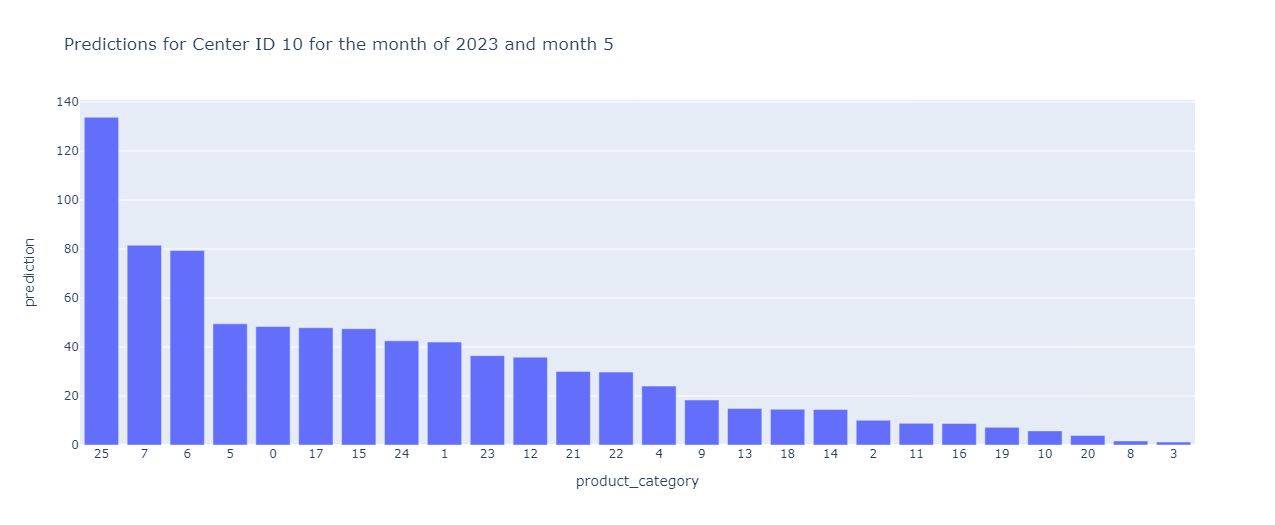